# Importações

In [1]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz, plot_tree
from sklearn import tree
import graphviz
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
import six
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


sns.set()

# Funções Auxiliares

In [6]:
def min_max_values(df):
    for index in df.columns:
        print(f'{index} - min: {df[index].min()}, max:{df[index].max()}')

In [7]:
def exclude_duplicated(data):
    return data.drop_duplicates()

In [8]:
def remove_outliers(dados):
    z = np.abs(stats.zscore(dados))
    return dados[(z<3).all(axis=1)]

In [9]:
def plot_conf():
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Especificidade(Taxa de Falso Positivo)')
    plt.ylabel('Sensibilidade(Taxa de Verdadeiro Positivo)')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()   # Display

In [10]:
def plot_dt_graph(X, modelo):
    features = X.columns
    dot_data = export_graphviz(modelo, out_file=None, 
                               filled = True, rounded = True,
                               feature_names=features,
                               class_names = ['não', 'sim'])
    grafico = graphviz.Source(dot_data)
    return grafico

In [11]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], Edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(Edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [12]:
def order_df_by_algortihm(df):
    df = df.sort_values(["Acurácia", "AUC"], ascending=False)
    df.drop(['Tratamento', 'F1_score', 'Taxa_VP', 'Precisão', 'Classe_retirada'], axis='columns', inplace=True)
    df = df.drop_duplicates(subset='Algoritmo', keep='first')
    df = df.assign(Acurácia = df.Acurácia)
    df = df.assign(AUC = df.AUC).round(3)
    return df.sort_values(by=['Algoritmo'],ascending=True)


# Recuperando os modelos de AM

In [13]:
def get_all_models():
    models = []
    n_trees = [10, 50, 100, 500, 1000, 5000]
    models.append(('LR', LogisticRegression(max_iter=10000)))
    models.append(('NB', make_pipeline(StandardScaler(), GaussianNB())))
    models.append(('SVM', make_pipeline(StandardScaler(), SVC(kernel='poly', probability=True, gamma='scale', C=50))))
    models.append(('RF', RandomForestClassifier(random_state = 0)))
    models.append(('DT', DecisionTreeClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1,random_state = 0)))
    models.append(('GB', GradientBoostingClassifier(random_state=0)))
    models.append((f'ADA LR', AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=1000),random_state=0)))
  
    return models


In [14]:
def models_dict():
    models = {
        'LR': LogisticRegression(max_iter=1000),
        'NB': make_pipeline(StandardScaler(), GaussianNB()),
        'SVM': make_pipeline(StandardScaler(), SVC(kernel='poly', probability=True, gamma='scale', C=50)),
        'RF': RandomForestClassifier(random_state = 0),
        'MLP': MLPClassifier(random_state=0, max_iter=1000),
        'DT': DecisionTreeClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1,random_state = 0),
        #'GB': GradientBoostingClassifier(random_state=0),
        #'ADA LR':  AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=1000),random_state=0)
    }
    
    return models

# Avaliando um modelo

In [15]:
def evaluate_model(models,tratamento, classe, X_train, X_test, y_train, y_test, result):
    scores = list()
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = round(accuracy_score(y_test, y_pred),3) * 100
        y_prob = model.predict_proba(X_test)[:,1]
        false_positive, true_positive, threshold = roc_curve(y_test, y_prob)  
        report = classification_report(y_test, y_pred, output_dict=True)
        scores.append(acc)
        auc = round(roc_auc_score(y_test, model.predict(X_test)),3)
        result['Algoritmo'].append(name)
        result['Acurácia'].append(acc)
        result['F1_score'].append(report['macro avg']['f1-score'])
        result['Taxa_VP'].append(report['macro avg']['recall'])
        result['Precisão'].append(report['macro avg']['precision'])
        result['Tratamento'].append(tratamento)
        result['Classe_retirada'].append(classe)
        result['AUC'].append(auc)
        plt.plot(false_positive, true_positive, label='%s ROC (AUC = %0.4f)' % (name, auc))
    plot_conf()
    
    return pd.DataFrame(result), scores, model

In [16]:
def evaluate_model_voting(models, X_train, X_test, y_train, y_test):
  # fit and evaluate the models
    scores = list()
    for _, model in models:
        # fit the model
        model.fit(X_train, y_train)
        # evaluate the model
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        # store the performance
        scores.append(acc)
        # report model performance
    return scores

# Plotando Matriz de confusão

In [17]:
def plot_cm(models, X_train, X_test, y_train, y_test):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=[1,0])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, colorbar=False)
        disp.plot()
        disp.ax_.set_title(name)
        plt.grid(False)
    plt.show()

In [18]:
def plot_cm3(models, X_train, X_test, y_train, y_test):
    for name, model in models.items():
        model.fit(X_train, y_train)
        disp = ConfusionMatrixDisplay.from_estimator(model,X_test, y_test, colorbar=False)
        disp.ax_.set_title(name)
        plt.grid(False)
    plt.show()

In [19]:
def plot_cm2(classifiers, X_train, X_test, y_train, y_test):
    f, axes = plt.subplots(1, 6, figsize=(20, 6), sharey='row')
    for i, (key, classifier) in enumerate(classifiers.items()):
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        cf_matrix = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i])
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        disp.ax_.grid(False)
        
        if i!=0:
            disp.ax_.set_ylabel('')
    
    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    f.colorbar(disp.im_, ax=axes)
    plt.show()

# Correlacionados

<AxesSubplot:>

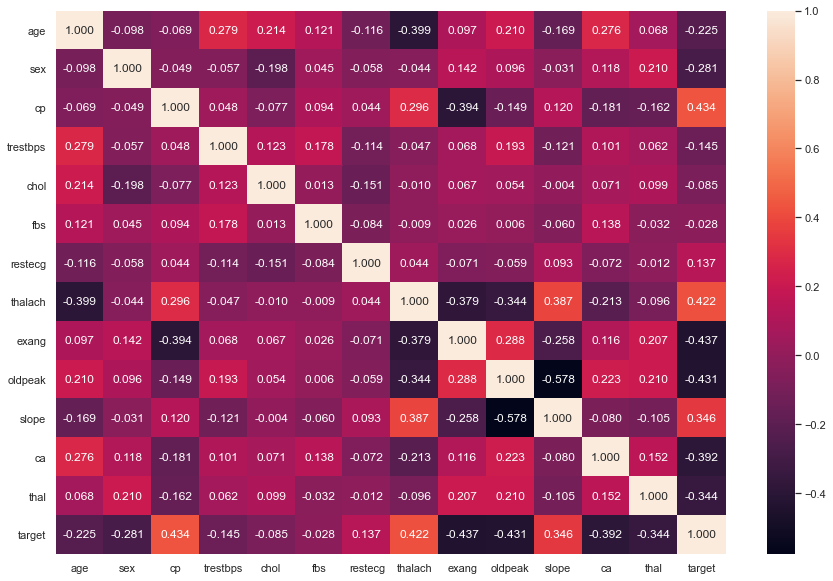

In [20]:
data = pd.read_csv('A:\wellkamp\TCC\heart.csv')

matriz_correlacao = data.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (15, 10))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

## Retirando chol

# Importando os dados

In [21]:
data = pd.read_csv('A:\wellkamp\TCC\heart.csv')

data.shape

(303, 14)

# Valores Faltantes

In [22]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [23]:
data.isnull().values.any()

False

In [24]:
data[data.duplicated(keep=False)]

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
163   38    1   2       138   175    0        1      173      0      0.0   
164   38    1   2       138   175    0        1      173      0      0.0   

     slope  ca  thal  target  
163      2   4     2       1  
164      2   4     2       1

In [25]:
dados_v1 = exclude_duplicated(data)

dados_v1.shape

(302, 14)

In [26]:
dados_v2 = remove_outliers(dados_v1)

dados_v2.shape

(287, 14)

In [27]:
data.shape

(303, 14)

In [28]:
data.tail()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
298      1   0     3       0  
299      1   0     3       0  
300      1   2     3       0  
301      1   1     3       0  
302      1   1     2       0

<AxesSubplot:>

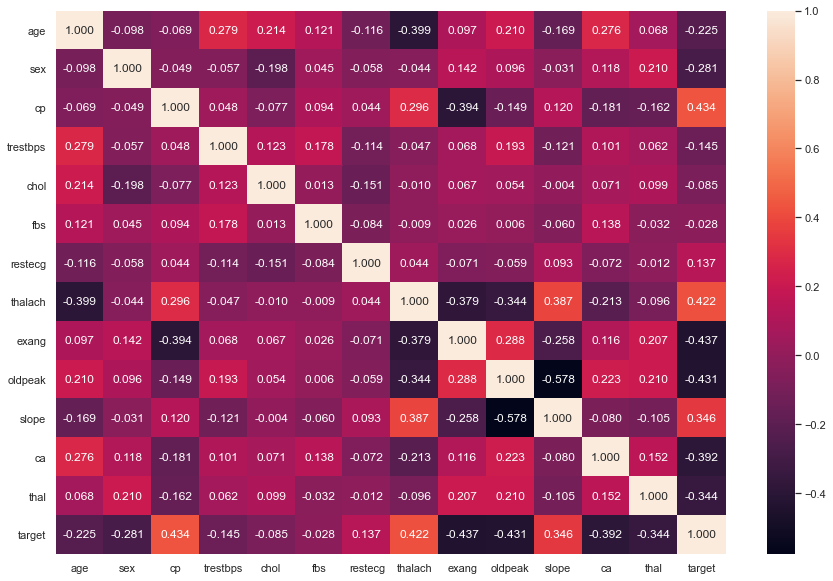

In [29]:
data = pd.read_csv('A:\wellkamp\TCC\heart.csv')

matriz_correlacao = data.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (15, 10))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

<AxesSubplot:>

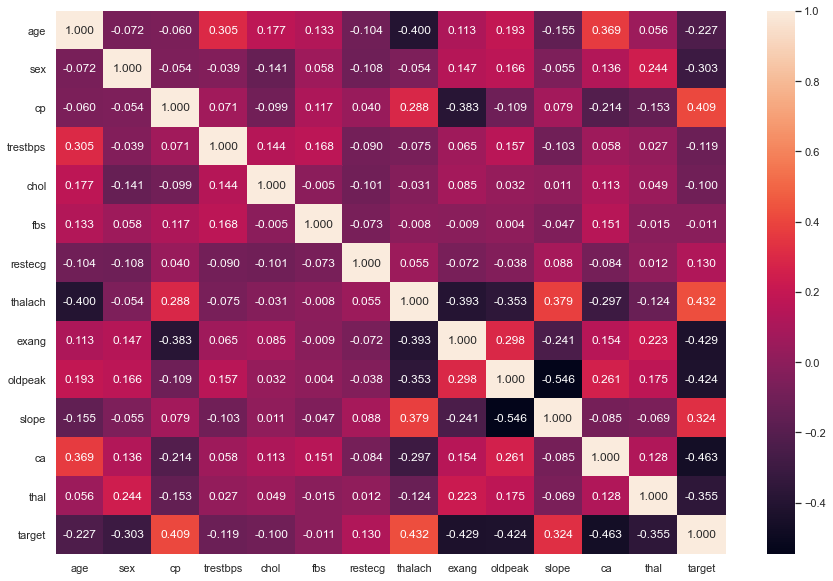

In [30]:
data = pd.read_csv('A:\wellkamp\TCC\heart.csv')

matriz_correlacao = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (15, 10))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

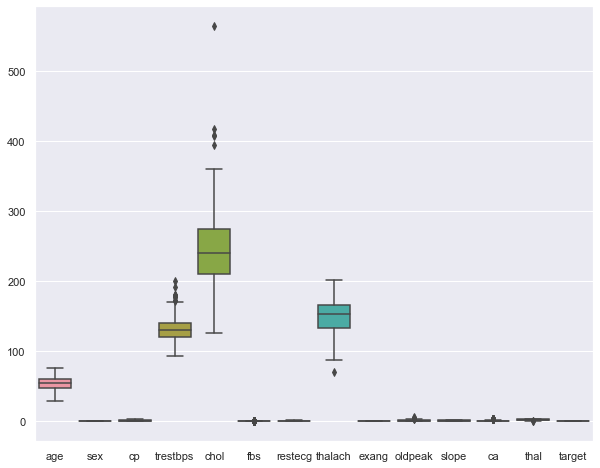

In [31]:
plt.figure(figsize=(10,8))
ax = sns.boxplot(data=data)
plt.show()

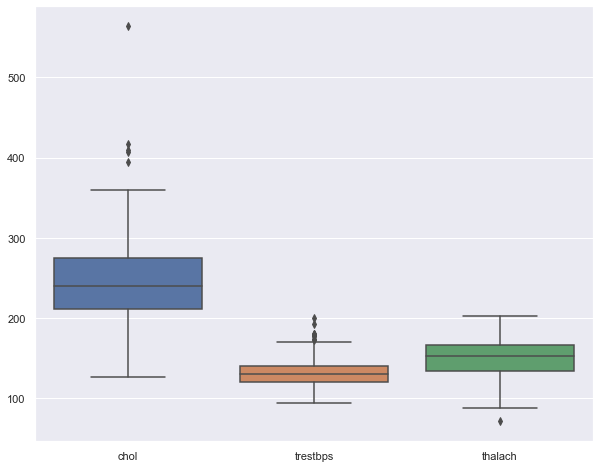

In [32]:
plt.figure(figsize=(10,8))
sns.boxplot(data=data[['chol','trestbps', 'thalach']])
plt.show()

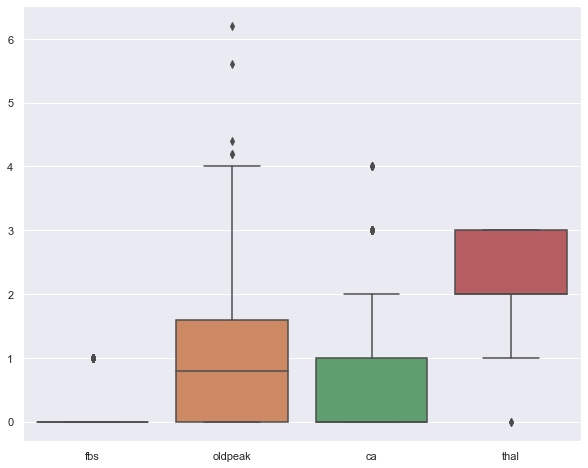

In [33]:
plt.figure(figsize=(10,8))
sns.boxplot(data=data[['fbs','oldpeak', 'ca', 'thal']])
plt.show()

# Resultados

In [34]:
results = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

trest = 'trestbps'
chol = 'chol'
fbs = 'fbs'
restecg= 'restecg'
all_classes = 'todas'

## Sem o tratamento de dados

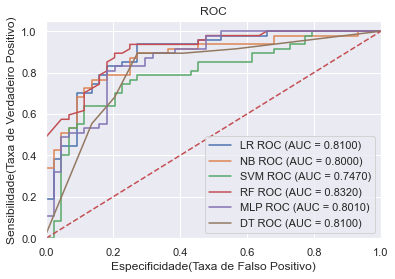

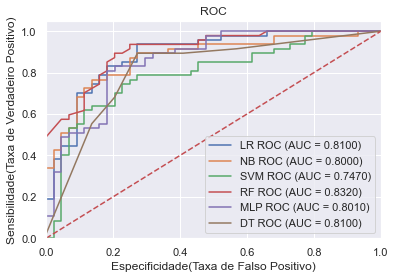

Algoritmo  Tratamento  Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False            False      81.3  0.810903  0.810445   
1        NB       False            False      80.2  0.800244  0.799807   
2       SVM       False            False      74.7  0.747131  0.747340   
3        RF       False            False      83.5  0.833150  0.832447   
4       MLP       False            False      80.2  0.801599  0.801257   
5        DT       False            False      81.3  0.810903  0.810445   

   Precisão    AUC  
0  0.821321  0.810  
1  0.807845  0.800  
2  0.747101  0.747  
3  0.844094  0.832  
4  0.802721  0.801  
5  0.821321  0.810

In [35]:
X = data.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
y = data.iloc[:, -1]

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

models = models_dict()

df_results, _, _ = evaluate_model(models, False, False, X_train, X_test, y_train, y_test, results)

df, acc, model = evaluate_model(models, False, False, X_train, X_test, y_train, y_test, result)
df

[Text(558.0, 713.475, 'cp <= 0.5\ngini = 0.494\nsamples = 212\nvalue = [94, 118]\nclass = sim'),
 Text(279.0, 509.625, 'ca <= 0.5\ngini = 0.415\nsamples = 102\nvalue = [72, 30]\nclass = não'),
 Text(139.5, 305.775, 'thal <= 2.5\ngini = 0.492\nsamples = 48\nvalue = [21, 27]\nclass = sim'),
 Text(69.75, 101.92499999999995, 'gini = 0.328\nsamples = 29\nvalue = [6, 23]\nclass = sim'),
 Text(209.25, 101.92499999999995, 'gini = 0.332\nsamples = 19\nvalue = [15, 4]\nclass = não'),
 Text(418.5, 305.775, 'age <= 63.5\ngini = 0.105\nsamples = 54\nvalue = [51, 3]\nclass = não'),
 Text(348.75, 101.92499999999995, 'gini = 0.0\nsamples = 43\nvalue = [43, 0]\nclass = não'),
 Text(488.25, 101.92499999999995, 'gini = 0.397\nsamples = 11\nvalue = [8, 3]\nclass = não'),
 Text(837.0, 509.625, 'oldpeak <= 1.95\ngini = 0.32\nsamples = 110\nvalue = [22, 88]\nclass = sim'),
 Text(697.5, 305.775, 'thalach <= 152.5\ngini = 0.255\nsamples = 100\nvalue = [15, 85]\nclass = sim'),
 Text(627.75, 101.92499999999995, 

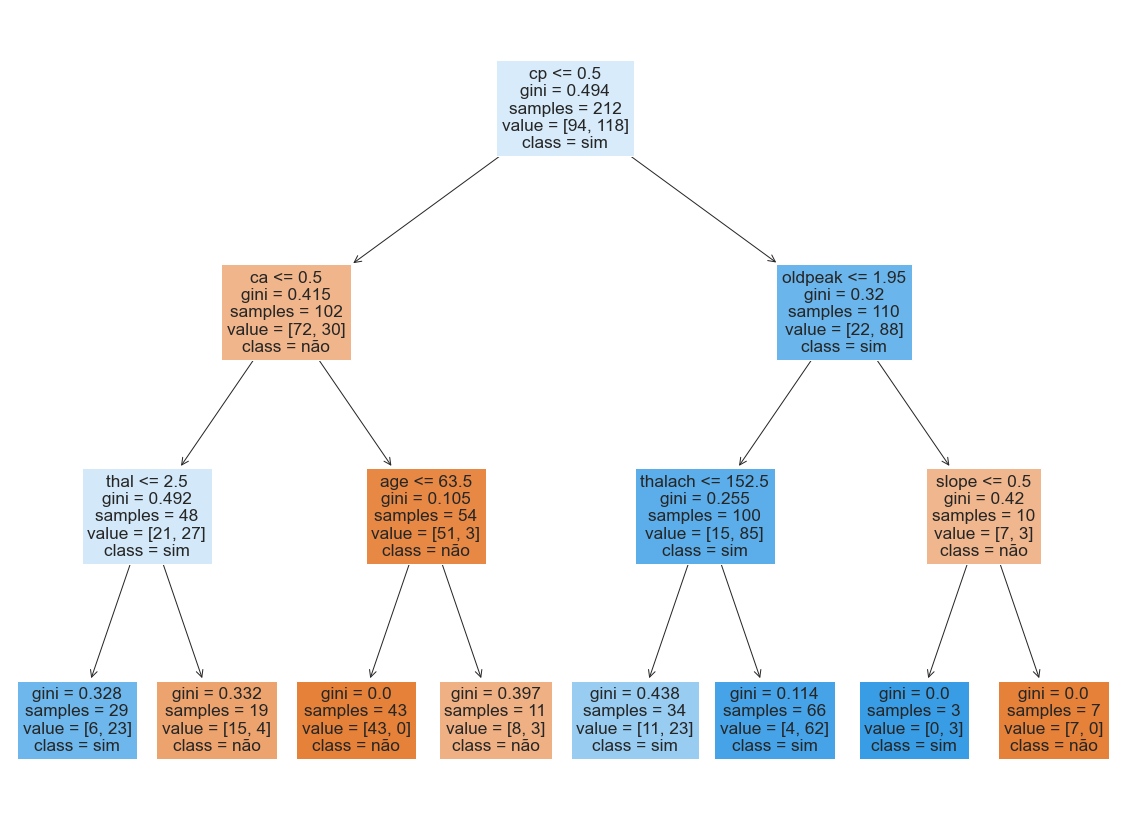

In [36]:
fig = plt.figure(figsize=(20,15))
plot_tree(model, feature_names=X.columns, filled=True, class_names=['não', 'sim'])

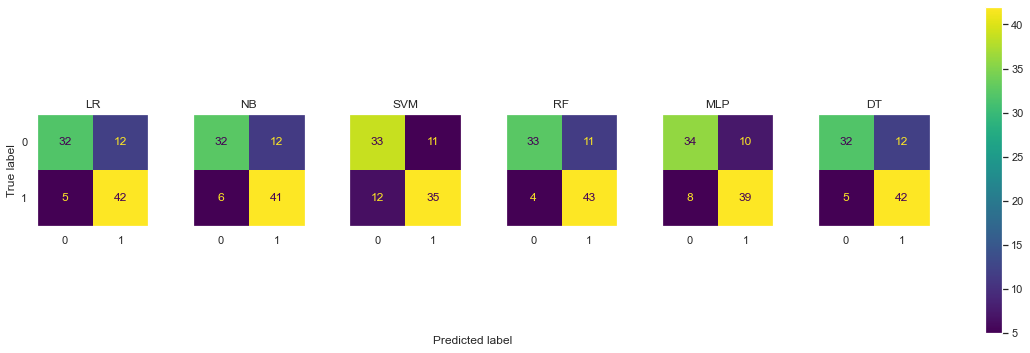

In [37]:
plot_cm2(models, X_train, X_test, y_train, y_test)

## Sem tratamento e retirando a class trestbps

<AxesSubplot:>

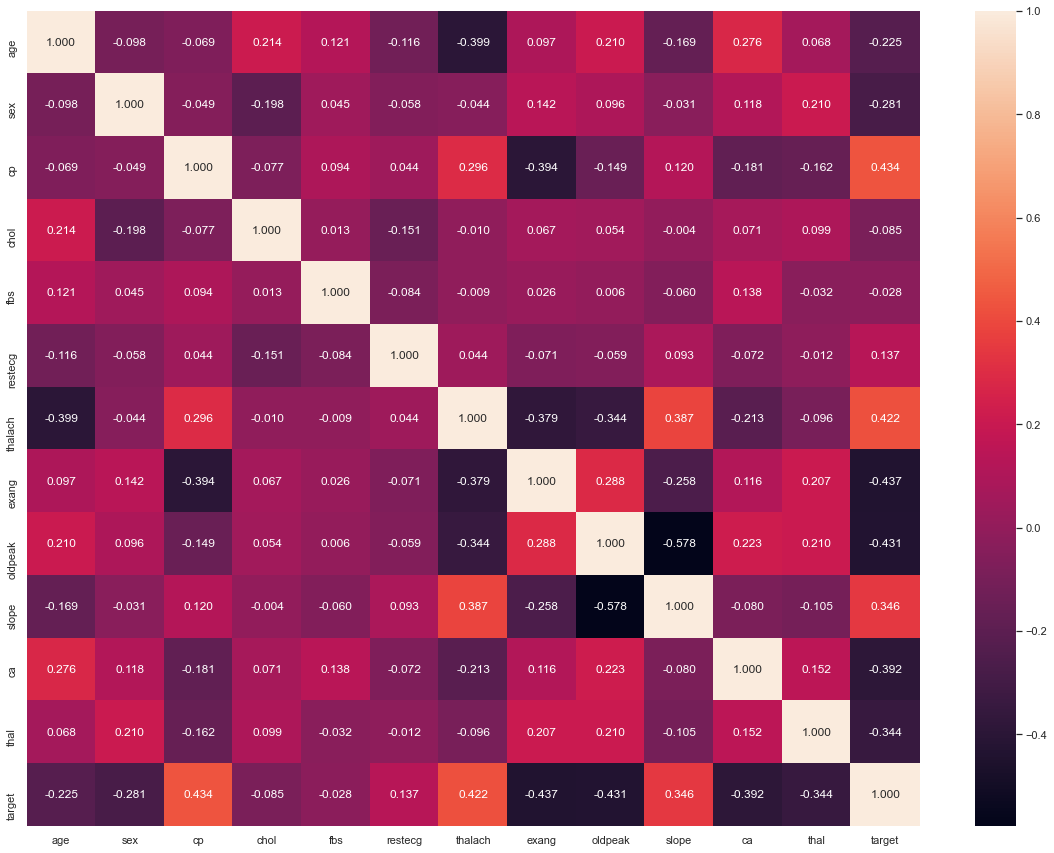

In [38]:
X = data.iloc[:, [0,1,2,4,5,6,7,8,9,10,11,12]].values
y = data.iloc[:, -1].values

matriz_correlacao = data.iloc[:, [0,1,2,4,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

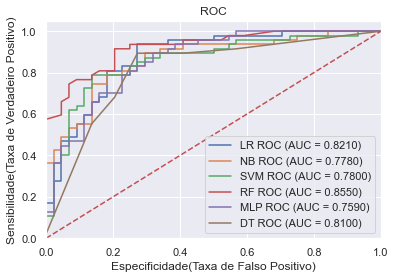

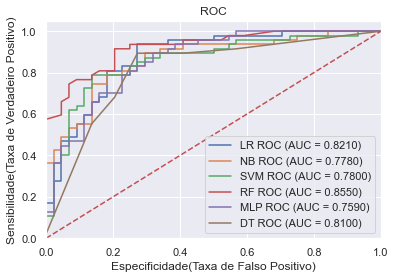

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False        trestbps      82.4  0.821569  0.821083   
1        NB       False        trestbps      78.0  0.778049  0.777805   
2       SVM       False        trestbps      78.0  0.779981  0.779981   
3        RF       False        trestbps      85.7  0.856030  0.855174   
4       MLP       False        trestbps      75.8  0.758213  0.758704   
5        DT       False        trestbps      81.3  0.810903  0.810445   

   Precisão    AUC  
0  0.835354  0.821  
1  0.785253  0.778  
2  0.779981  0.780  
3  0.862179  0.855  
4  0.758454  0.759  
5  0.821321  0.810

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}
models = models_dict()

df_results, _, _ = evaluate_model(models, False, trest, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, False, trest, X_train, X_test, y_train, y_test, result)
df

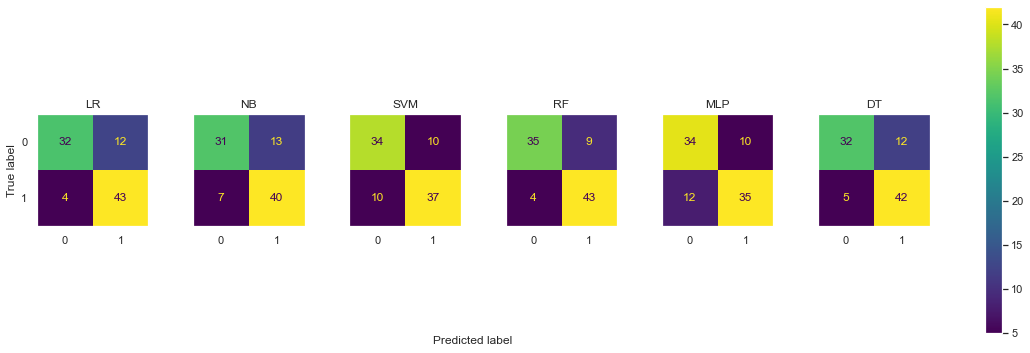

In [40]:
plot_cm2(models, X_train, X_test, y_train, y_test)

## Retirando chol

<AxesSubplot:>

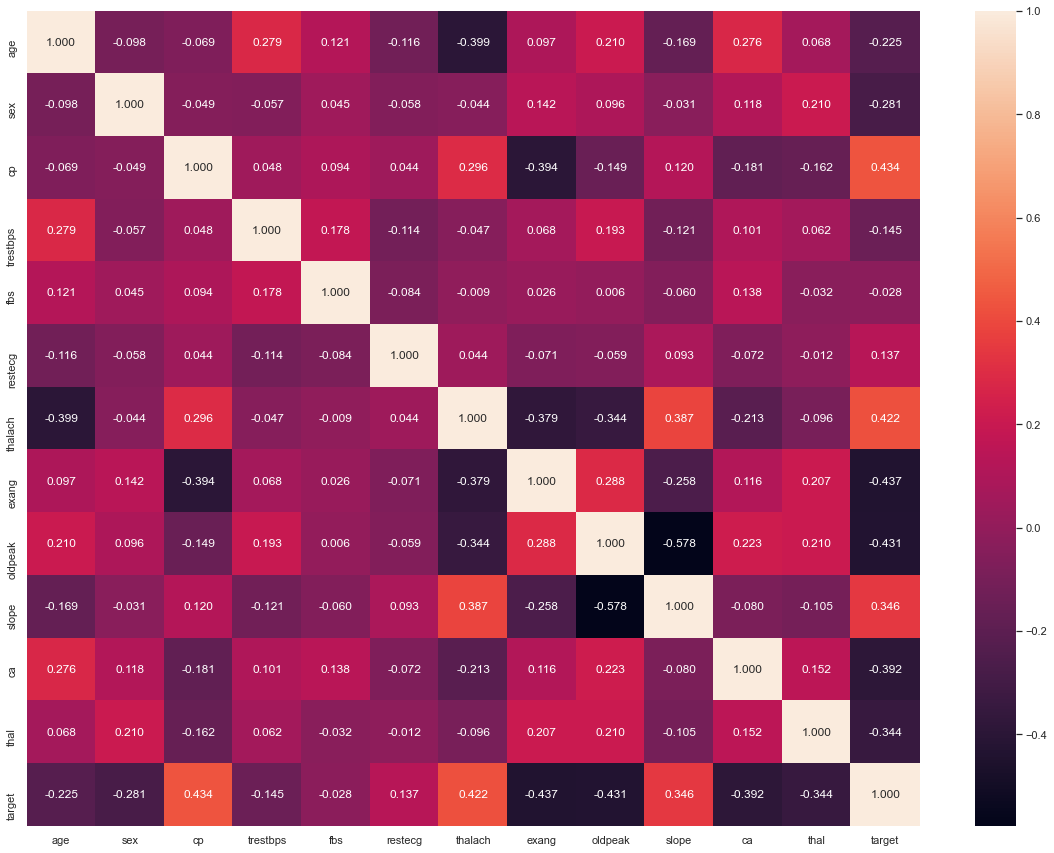

In [41]:
X = data.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12]].values
y = data.iloc[:, -1].values

matriz_correlacao = data.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

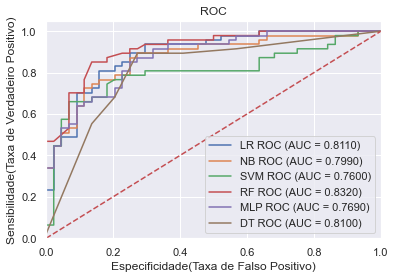

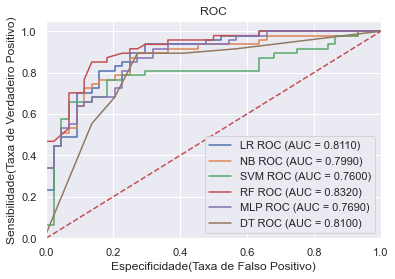

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False            chol      81.3  0.811732  0.811170   
1        NB       False            chol      80.2  0.799265  0.799081   
2       SVM       False            chol      75.8  0.757979  0.760155   
3        RF       False            chol      83.5  0.833150  0.832447   
4       MLP       False            chol      76.9  0.769119  0.769342   
5        DT       False            chol      81.3  0.810903  0.810445   

   Precisão    AUC  
0  0.817308  0.811  
1  0.812374  0.799  
2  0.762439  0.760  
3  0.844094  0.832  
4  0.769082  0.769  
5  0.821321  0.810

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}
models = models_dict()

df_results, _, _ = evaluate_model(models, False, chol, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, False, chol, X_train, X_test, y_train, y_test, result)
df

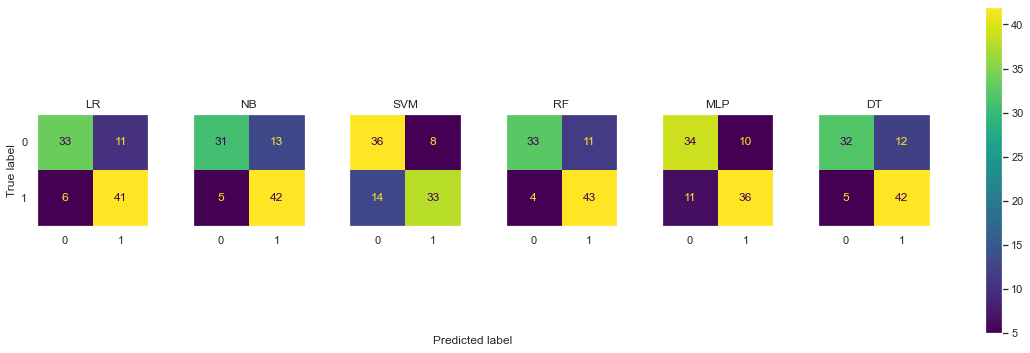

In [43]:
plot_cm2(models, X_train, X_test, y_train, y_test)

## Retirando fbs

<AxesSubplot:>

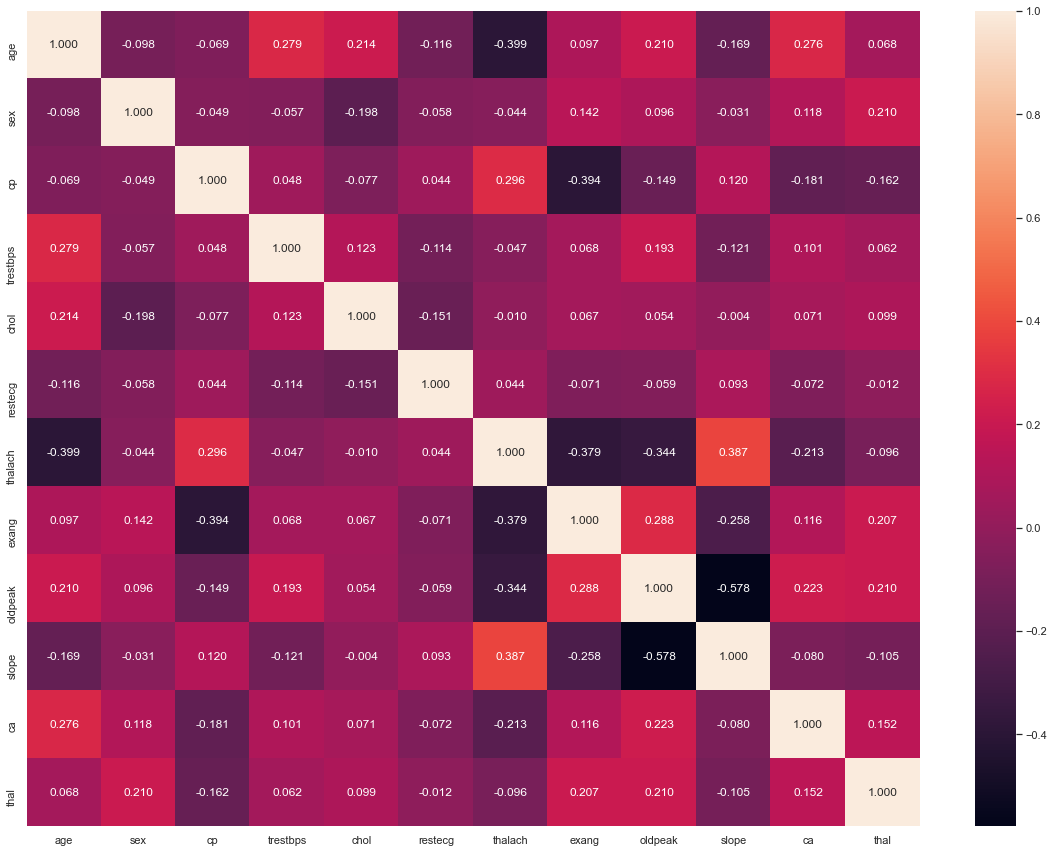

In [44]:
X = data.iloc[:, [0,1,2,3,4,6,7,8,9,10,11,12]].values
y = data.iloc[:, -1].values

matriz_correlacao = data.iloc[:, [0,1,2,3,4,6,7,8,9,10,11,12]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

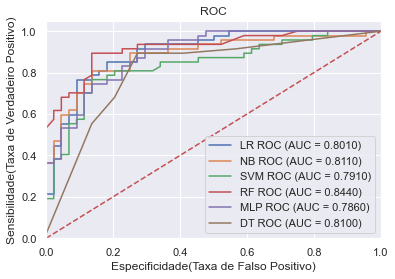

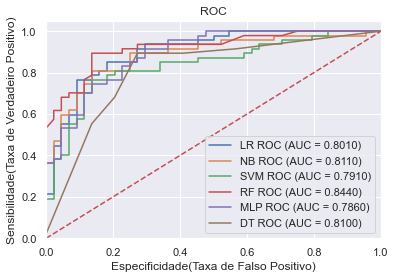

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False             fbs      80.2  0.801020  0.800532   
1        NB       False             fbs      81.3  0.811732  0.811170   
2       SVM       False             fbs      79.1  0.791108  0.791344   
3        RF       False             fbs      84.6  0.844634  0.843810   
4       MLP       False             fbs      79.1  0.784548  0.786267   
5        DT       False             fbs      81.3  0.810903  0.810445   

   Precisão    AUC  
0  0.804657  0.801  
1  0.817308  0.811  
2  0.791063  0.791  
3  0.853029  0.844  
4  0.818280  0.786  
5  0.821321  0.810

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, False, fbs, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, False, fbs, X_train, X_test, y_train, y_test, result)
df

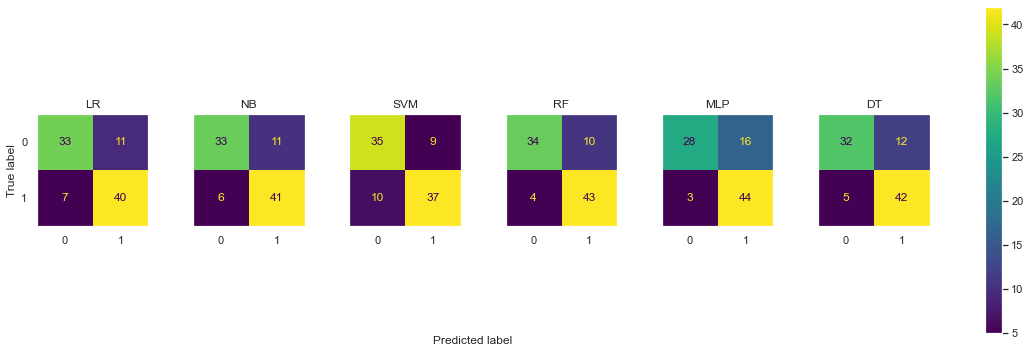

In [46]:
plot_cm2(models, X_train, X_test, y_train, y_test)

## Retirando a classe restecg

<AxesSubplot:>

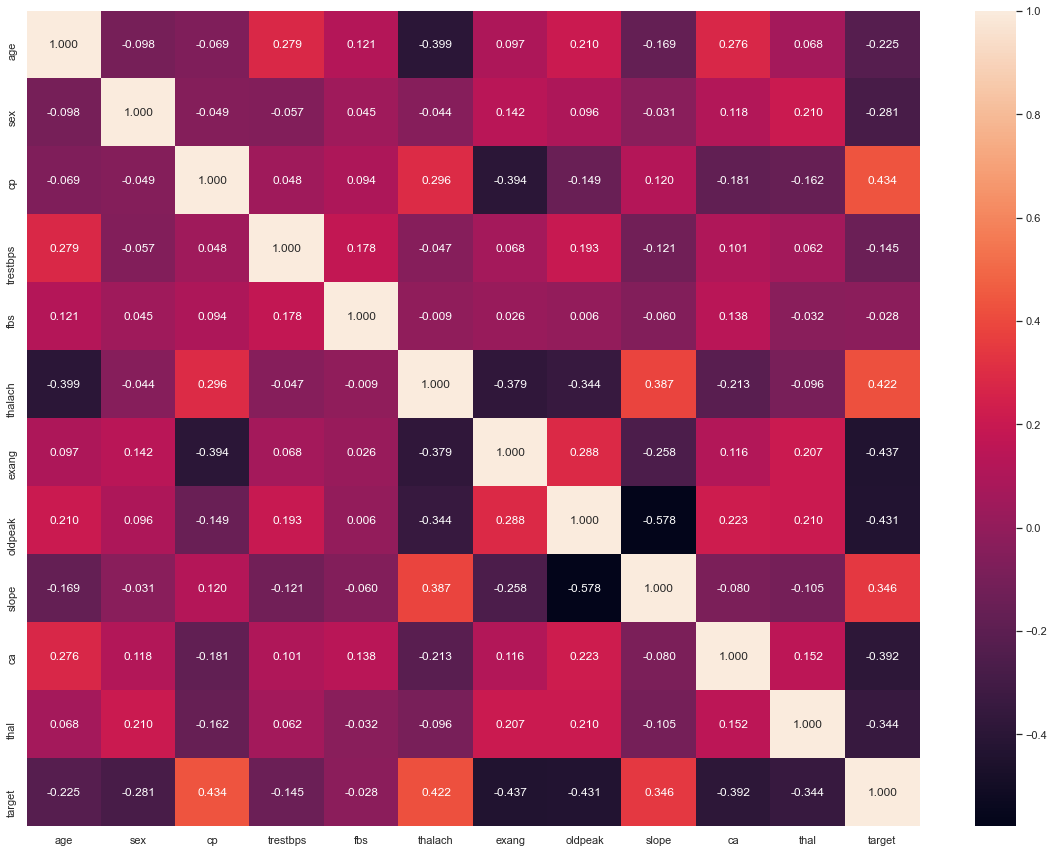

In [47]:
X = data.iloc[:, [0,1,2,3,4,5,7,8,9,10,11,12]].values
y = data.iloc[:, -1].values

matriz_correlacao = data.iloc[:, [0,1,2,3,5,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

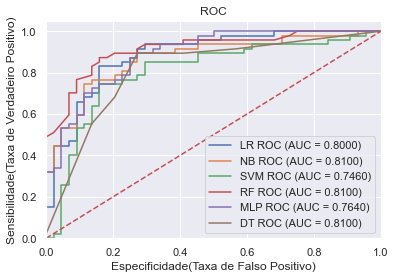

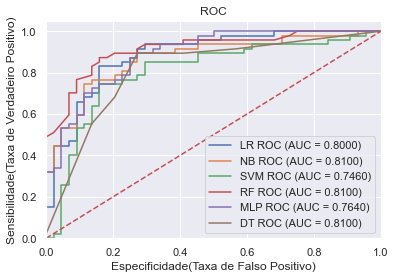

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False         restecg      80.2  0.800244  0.799807   
1        NB       False         restecg      81.3  0.810903  0.810445   
2       SVM       False         restecg      74.7  0.746149  0.745890   
3        RF       False         restecg      81.3  0.810903  0.810445   
4       MLP       False         restecg      76.9  0.759834  0.763540   
5        DT       False         restecg      81.3  0.810903  0.810445   

   Precisão    AUC  
0  0.807845  0.800  
1  0.821321  0.810  
2  0.748049  0.746  
3  0.821321  0.810  
4  0.803115  0.764  
5  0.821321  0.810

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, False, restecg, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, False, restecg, X_train, X_test, y_train, y_test, result)
df

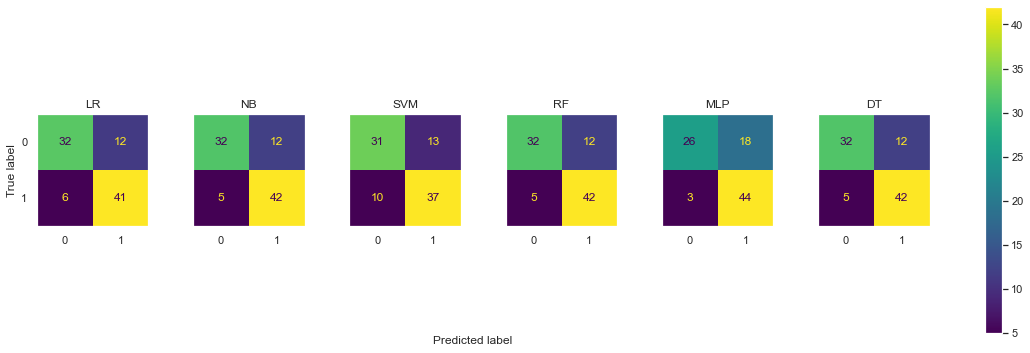

In [49]:
plot_cm2(models, X_train, X_test, y_train, y_test)

## Retirando todas as classes que possuem pouca correlação

<AxesSubplot:>

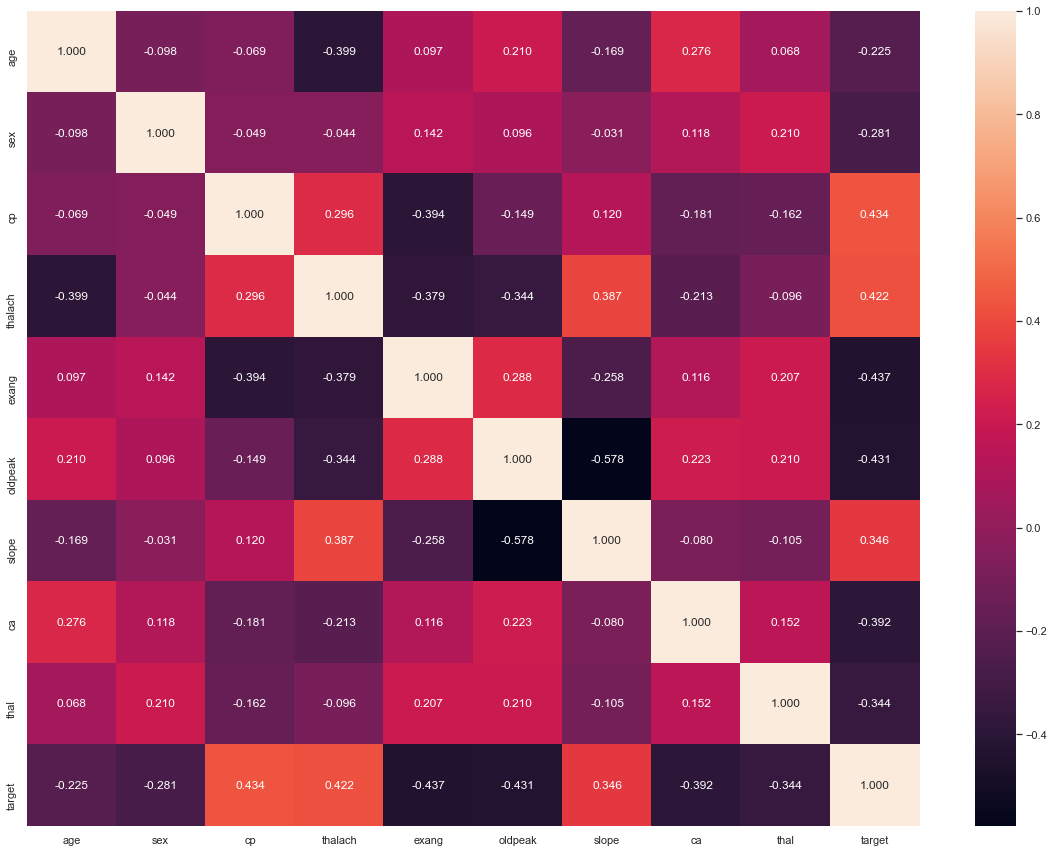

In [50]:
X = data.iloc[:, [0,1,2,7,8,9,10,11,12]].values
y = data.iloc[:, -1].values

matriz_correlacao = data.iloc[:, [0,1,2,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

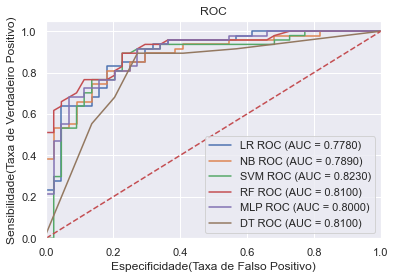

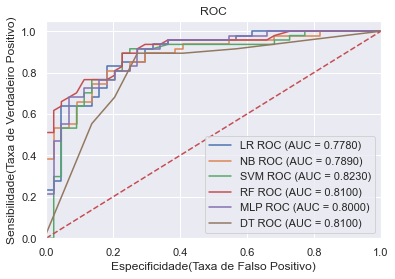

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR       False           todas      78.0  0.778049  0.777805   
1        NB       False           todas      79.1  0.789583  0.789168   
2       SVM       False           todas      82.4  0.823129  0.822534   
3        RF       False           todas      81.3  0.810903  0.810445   
4       MLP       False           todas      80.2  0.800244  0.799807   
5        DT       False           todas      81.3  0.810903  0.810445   

   Precisão    AUC  
0  0.785253  0.778  
1  0.794872  0.789  
2  0.826961  0.823  
3  0.821321  0.810  
4  0.807845  0.800  
5  0.821321  0.810

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, False, all_classes, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, False, all_classes, X_train, X_test, y_train, y_test, result)
df

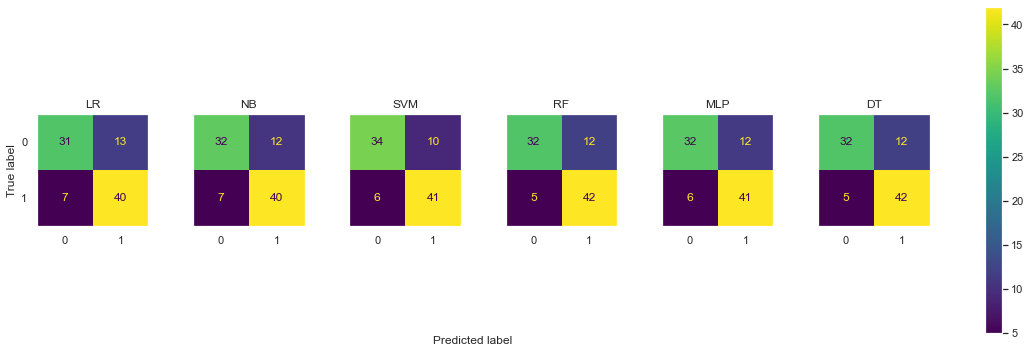

In [52]:
plot_cm2(models, X_train, X_test, y_train, y_test)

In [53]:
df_results

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0         LR       False           False      81.3  0.810903  0.810445   
1         NB       False           False      80.2  0.800244  0.799807   
2        SVM       False           False      74.7  0.747131  0.747340   
3         RF       False           False      83.5  0.833150  0.832447   
4        MLP       False           False      80.2  0.801599  0.801257   
5         DT       False           False      81.3  0.810903  0.810445   
6         LR       False        trestbps      82.4  0.821569  0.821083   
7         NB       False        trestbps      78.0  0.778049  0.777805   
8        SVM       False        trestbps      78.0  0.779981  0.779981   
9         RF       False        trestbps      85.7  0.856030  0.855174   
10       MLP       False        trestbps      75.8  0.758213  0.758704   
11        DT       False        trestbps      81.3  0.810903  0.810445   
12        LR       False            chol      81.3  0.811732  0.811170   
13        NB       False            chol      80.2  0.799265  0.799081   
14       SVM       False            chol      75.8  0.757979  0.760155   
15        RF       False            chol      83.5  0.833150  0.832447   
16       MLP       False            chol      76.9  0.769119  0.769342   
17        DT       False            chol      81.3  0.810903  0.810445   
18        LR       False             fbs      80.2  0.801020  0.800532   
19        NB       False             fbs      81.3  0.811732  0.811170   
20       SVM       False             fbs      79.1  0.791108  0.791344   
21        RF       False             fbs      84.6  0.844634  0.843810   
22       MLP       False             fbs      79.1  0.784548  0.786267   
23        DT       False             fbs      81.3  0.810903  0.810445   
24        LR       False         restecg      80.2  0.800244  0.799807   
25        NB       False         restecg      81.3  0.810903  0.810445   
26       SVM       False         restecg      74.7  0.746149  0.745890   
27        RF       False         restecg      81.3  0.810903  0.810445   
28       MLP       False         restecg      76.9  0.759834  0.763540   
29        DT       False         restecg      81.3  0.810903  0.810445   
30        LR       False           todas      78.0  0.778049  0.777805   
31        NB       False           todas      79.1  0.789583  0.789168   
32       SVM       False           todas      82.4  0.823129  0.822534   
33        RF       False           todas      81.3  0.810903  0.810445   
34       MLP       False           todas      80.2  0.800244  0.799807   
35        DT       False           todas      81.3  0.810903  0.810445   

    Precisão    AUC  
0   0.821321  0.810  
1   0.807845  0.800  
2   0.747101  0.747  
3   0.844094  0.832  
4   0.802721  0.801  
5   0.821321  0.810  
6   0.835354  0.821  
7   0.785253  0.778  
8   0.779981  0.780  
9   0.862179  0.855  
10  0.758454  0.759  
11  0.821321  0.810  
12  0.817308  0.811  
13  0.812374  0.799  
14  0.762439  0.760  
15  0.844094  0.832  
16  0.769082  0.769  
17  0.821321  0.810  
18  0.804657  0.801  
19  0.817308  0.811  
20  0.791063  0.791  
21  0.853029  0.844  
22  0.818280  0.786  
23  0.821321  0.810  
24  0.807845  0.800  
25  0.821321  0.810  
26  0.748049  0.746  
27  0.821321  0.810  
28  0.803115  0.764  
29  0.821321  0.810  
30  0.785253  0.778  
31  0.794872  0.789  
32  0.826961  0.823  
33  0.821321  0.810  
34  0.807845  0.800  
35  0.821321  0.810

In [54]:
df_results.sort_values(["Acurácia", "AUC"], ascending=False)


Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
9         RF       False        trestbps      85.7  0.856030  0.855174   
21        RF       False             fbs      84.6  0.844634  0.843810   
3         RF       False           False      83.5  0.833150  0.832447   
15        RF       False            chol      83.5  0.833150  0.832447   
32       SVM       False           todas      82.4  0.823129  0.822534   
6         LR       False        trestbps      82.4  0.821569  0.821083   
12        LR       False            chol      81.3  0.811732  0.811170   
19        NB       False             fbs      81.3  0.811732  0.811170   
0         LR       False           False      81.3  0.810903  0.810445   
5         DT       False           False      81.3  0.810903  0.810445   
11        DT       False        trestbps      81.3  0.810903  0.810445   
17        DT       False            chol      81.3  0.810903  0.810445   
23        DT       False             fbs      81.3  0.810903  0.810445   
25        NB       False         restecg      81.3  0.810903  0.810445   
27        RF       False         restecg      81.3  0.810903  0.810445   
29        DT       False         restecg      81.3  0.810903  0.810445   
33        RF       False           todas      81.3  0.810903  0.810445   
35        DT       False           todas      81.3  0.810903  0.810445   
4        MLP       False           False      80.2  0.801599  0.801257   
18        LR       False             fbs      80.2  0.801020  0.800532   
1         NB       False           False      80.2  0.800244  0.799807   
24        LR       False         restecg      80.2  0.800244  0.799807   
34       MLP       False           todas      80.2  0.800244  0.799807   
13        NB       False            chol      80.2  0.799265  0.799081   
20       SVM       False             fbs      79.1  0.791108  0.791344   
31        NB       False           todas      79.1  0.789583  0.789168   
22       MLP       False             fbs      79.1  0.784548  0.786267   
8        SVM       False        trestbps      78.0  0.779981  0.779981   
7         NB       False        trestbps      78.0  0.778049  0.777805   
30        LR       False           todas      78.0  0.778049  0.777805   
16       MLP       False            chol      76.9  0.769119  0.769342   
28       MLP       False         restecg      76.9  0.759834  0.763540   
14       SVM       False            chol      75.8  0.757979  0.760155   
10       MLP       False        trestbps      75.8  0.758213  0.758704   
2        SVM       False           False      74.7  0.747131  0.747340   
26       SVM       False         restecg      74.7  0.746149  0.745890   

    Precisão    AUC  
9   0.862179  0.855  
21  0.853029  0.844  
3   0.844094  0.832  
15  0.844094  0.832  
32  0.826961  0.823  
6   0.835354  0.821  
12  0.817308  0.811  
19  0.817308  0.811  
0   0.821321  0.810  
5   0.821321  0.810  
11  0.821321  0.810  
17  0.821321  0.810  
23  0.821321  0.810  
25  0.821321  0.810  
27  0.821321  0.810  
29  0.821321  0.810  
33  0.821321  0.810  
35  0.821321  0.810  
4   0.802721  0.801  
18  0.804657  0.801  
1   0.807845  0.800  
24  0.807845  0.800  
34  0.807845  0.800  
13  0.812374  0.799  
20  0.791063  0.791  
31  0.794872  0.789  
22  0.818280  0.786  
8   0.779981  0.780  
7   0.785253  0.778  
30  0.785253  0.778  
16  0.769082  0.769  
28  0.803115  0.764  
14  0.762439  0.760  
10  0.758454  0.759  
2   0.747101  0.747  
26  0.748049  0.746

In [55]:
df_sorted_sem = df_results.sort_values(["Acurácia", "AUC"], ascending=False)

In [56]:
df_sorted_sem

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
9         RF       False        trestbps      85.7  0.856030  0.855174   
21        RF       False             fbs      84.6  0.844634  0.843810   
3         RF       False           False      83.5  0.833150  0.832447   
15        RF       False            chol      83.5  0.833150  0.832447   
32       SVM       False           todas      82.4  0.823129  0.822534   
6         LR       False        trestbps      82.4  0.821569  0.821083   
12        LR       False            chol      81.3  0.811732  0.811170   
19        NB       False             fbs      81.3  0.811732  0.811170   
0         LR       False           False      81.3  0.810903  0.810445   
5         DT       False           False      81.3  0.810903  0.810445   
11        DT       False        trestbps      81.3  0.810903  0.810445   
17        DT       False            chol      81.3  0.810903  0.810445   
23        DT       False             fbs      81.3  0.810903  0.810445   
25        NB       False         restecg      81.3  0.810903  0.810445   
27        RF       False         restecg      81.3  0.810903  0.810445   
29        DT       False         restecg      81.3  0.810903  0.810445   
33        RF       False           todas      81.3  0.810903  0.810445   
35        DT       False           todas      81.3  0.810903  0.810445   
4        MLP       False           False      80.2  0.801599  0.801257   
18        LR       False             fbs      80.2  0.801020  0.800532   
1         NB       False           False      80.2  0.800244  0.799807   
24        LR       False         restecg      80.2  0.800244  0.799807   
34       MLP       False           todas      80.2  0.800244  0.799807   
13        NB       False            chol      80.2  0.799265  0.799081   
20       SVM       False             fbs      79.1  0.791108  0.791344   
31        NB       False           todas      79.1  0.789583  0.789168   
22       MLP       False             fbs      79.1  0.784548  0.786267   
8        SVM       False        trestbps      78.0  0.779981  0.779981   
7         NB       False        trestbps      78.0  0.778049  0.777805   
30        LR       False           todas      78.0  0.778049  0.777805   
16       MLP       False            chol      76.9  0.769119  0.769342   
28       MLP       False         restecg      76.9  0.759834  0.763540   
14       SVM       False            chol      75.8  0.757979  0.760155   
10       MLP       False        trestbps      75.8  0.758213  0.758704   
2        SVM       False           False      74.7  0.747131  0.747340   
26       SVM       False         restecg      74.7  0.746149  0.745890   

    Precisão    AUC  
9   0.862179  0.855  
21  0.853029  0.844  
3   0.844094  0.832  
15  0.844094  0.832  
32  0.826961  0.823  
6   0.835354  0.821  
12  0.817308  0.811  
19  0.817308  0.811  
0   0.821321  0.810  
5   0.821321  0.810  
11  0.821321  0.810  
17  0.821321  0.810  
23  0.821321  0.810  
25  0.821321  0.810  
27  0.821321  0.810  
29  0.821321  0.810  
33  0.821321  0.810  
35  0.821321  0.810  
4   0.802721  0.801  
18  0.804657  0.801  
1   0.807845  0.800  
24  0.807845  0.800  
34  0.807845  0.800  
13  0.812374  0.799  
20  0.791063  0.791  
31  0.794872  0.789  
22  0.818280  0.786  
8   0.779981  0.780  
7   0.785253  0.778  
30  0.785253  0.778  
16  0.769082  0.769  
28  0.803115  0.764  
14  0.762439  0.760  
10  0.758454  0.759  
2   0.747101  0.747  
26  0.748049  0.746

In [57]:
df_sorted_sem.drop(['Tratamento', 'F1_score', 'Taxa_VP', 'Precisão'], axis='columns', inplace=True)

In [58]:
df_sorted_sem

Algoritmo Classe_retirada  Acurácia    AUC
9         RF        trestbps      85.7  0.855
21        RF             fbs      84.6  0.844
3         RF           False      83.5  0.832
15        RF            chol      83.5  0.832
32       SVM           todas      82.4  0.823
6         LR        trestbps      82.4  0.821
12        LR            chol      81.3  0.811
19        NB             fbs      81.3  0.811
0         LR           False      81.3  0.810
5         DT           False      81.3  0.810
11        DT        trestbps      81.3  0.810
17        DT            chol      81.3  0.810
23        DT             fbs      81.3  0.810
25        NB         restecg      81.3  0.810
27        RF         restecg      81.3  0.810
29        DT         restecg      81.3  0.810
33        RF           todas      81.3  0.810
35        DT           todas      81.3  0.810
4        MLP           False      80.2  0.801
18        LR             fbs      80.2  0.801
1         NB           False      80.2  0.800
24        LR         restecg      80.2  0.800
34       MLP           todas      80.2  0.800
13        NB            chol      80.2  0.799
20       SVM             fbs      79.1  0.791
31        NB           todas      79.1  0.789
22       MLP             fbs      79.1  0.786
8        SVM        trestbps      78.0  0.780
7         NB        trestbps      78.0  0.778
30        LR           todas      78.0  0.778
16       MLP            chol      76.9  0.769
28       MLP         restecg      76.9  0.764
14       SVM            chol      75.8  0.760
10       MLP        trestbps      75.8  0.759
2        SVM           False      74.7  0.747
26       SVM         restecg      74.7  0.746

In [59]:
df_sorted_sem.query('Classe_retirada == "trestbps"')

Algoritmo Classe_retirada  Acurácia    AUC
9         RF        trestbps      85.7  0.855
6         LR        trestbps      82.4  0.821
11        DT        trestbps      81.3  0.810
8        SVM        trestbps      78.0  0.780
7         NB        trestbps      78.0  0.778
10       MLP        trestbps      75.8  0.759

In [60]:
df_sorted_sem.query('Classe_retirada != "RF"')

Algoritmo Classe_retirada  Acurácia    AUC
9         RF        trestbps      85.7  0.855
21        RF             fbs      84.6  0.844
3         RF           False      83.5  0.832
15        RF            chol      83.5  0.832
32       SVM           todas      82.4  0.823
6         LR        trestbps      82.4  0.821
12        LR            chol      81.3  0.811
19        NB             fbs      81.3  0.811
0         LR           False      81.3  0.810
5         DT           False      81.3  0.810
11        DT        trestbps      81.3  0.810
17        DT            chol      81.3  0.810
23        DT             fbs      81.3  0.810
25        NB         restecg      81.3  0.810
27        RF         restecg      81.3  0.810
29        DT         restecg      81.3  0.810
33        RF           todas      81.3  0.810
35        DT           todas      81.3  0.810
4        MLP           False      80.2  0.801
18        LR             fbs      80.2  0.801
1         NB           False      80.2  0.800
24        LR         restecg      80.2  0.800
34       MLP           todas      80.2  0.800
13        NB            chol      80.2  0.799
20       SVM             fbs      79.1  0.791
31        NB           todas      79.1  0.789
22       MLP             fbs      79.1  0.786
8        SVM        trestbps      78.0  0.780
7         NB        trestbps      78.0  0.778
30        LR           todas      78.0  0.778
16       MLP            chol      76.9  0.769
28       MLP         restecg      76.9  0.764
14       SVM            chol      75.8  0.760
10       MLP        trestbps      75.8  0.759
2        SVM           False      74.7  0.747
26       SVM         restecg      74.7  0.746

# Melhores resultados sem o tratamento de dados

In [61]:
df_sem = df_sorted_sem.drop_duplicates(subset='Algoritmo', keep='first')
df_sem

Algoritmo Classe_retirada  Acurácia    AUC
9         RF        trestbps      85.7  0.855
32       SVM           todas      82.4  0.823
6         LR        trestbps      82.4  0.821
19        NB             fbs      81.3  0.811
5         DT           False      81.3  0.810
4        MLP           False      80.2  0.801

# Com tratamento dos dados

In [62]:
results = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

trest = 'trestbps'
chol = 'chol'
fbs = 'thalach'
restecg= 'restecg'
all_classes = 'todas'

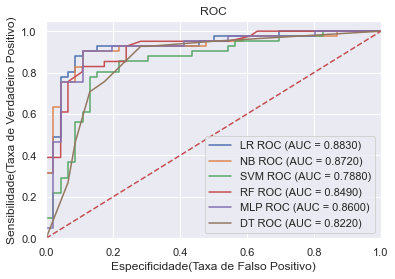

Algoritmo  Tratamento  Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True            False      88.5  0.884309  0.883351   
1        NB        True            False      87.4  0.872959  0.872481   
2       SVM        True            False      79.3  0.789742  0.788441   
3        RF        True            False      85.1  0.849861  0.849417   
4       MLP        True            False      86.2  0.861170  0.860286   
5        DT        True            False      81.6  0.815483  0.822110   

   Precisão    AUC  
0  0.886218  0.883  
1  0.873670  0.872  
2  0.798901  0.788  
3  0.850532  0.849  
4  0.862981  0.860  
5  0.830882  0.822

In [63]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

models = models_dict()

# df_results, _, _ = evaluate_model(models, True, False, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, False, X_train, X_test, y_train, y_test, result)
df


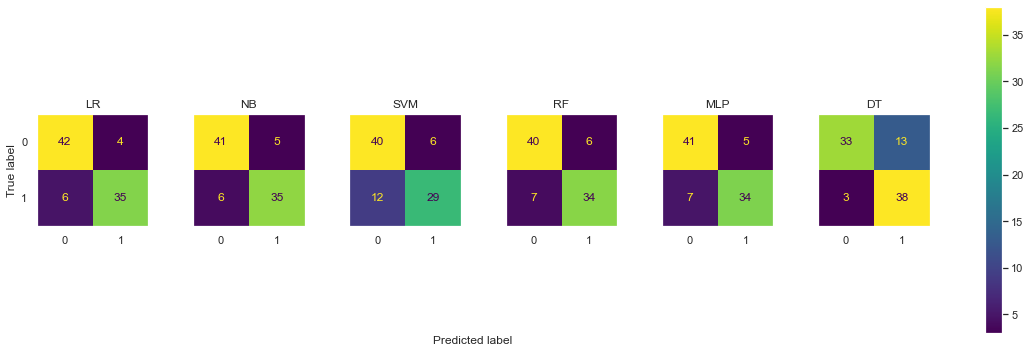

In [64]:
plot_cm2(models, X_train, X_test, y_train, y_test)

# Com tratamento e retirando a classe trest

<AxesSubplot:>

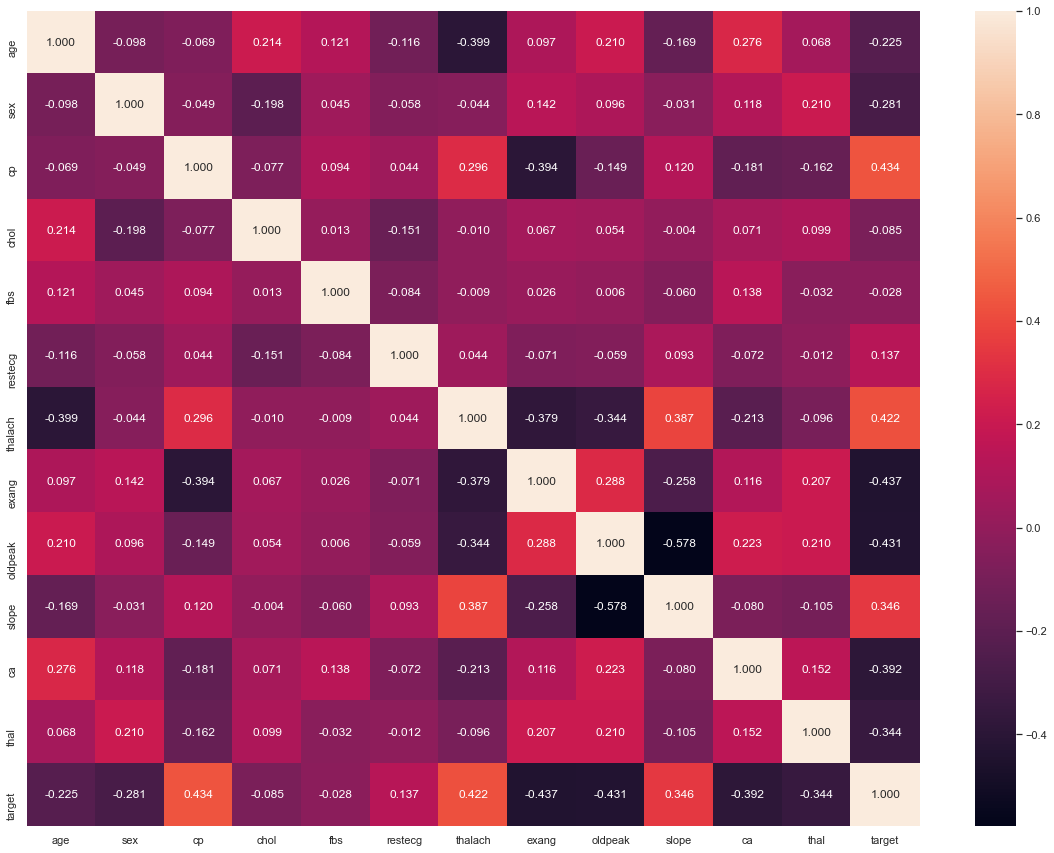

In [65]:
X = dados_v2.iloc[:, [0,1,2,4,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, -1].values


matriz_correlacao = data.iloc[:, [0,1,2,4,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

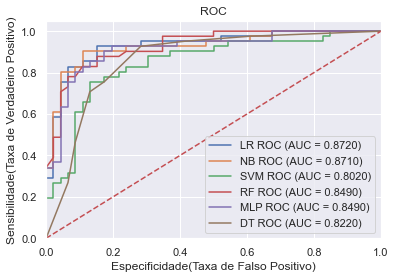

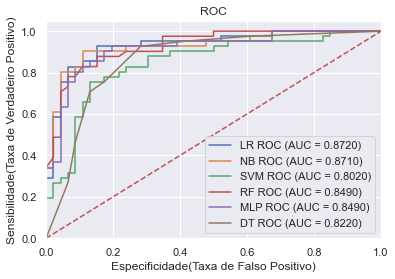

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True        trestbps      87.4  0.872959  0.872481   
1        NB        True        trestbps      87.4  0.872485  0.871156   
2       SVM        True        trestbps      80.5  0.802931  0.801962   
3        RF        True        trestbps      85.1  0.849861  0.849417   
4       MLP        True        trestbps      85.1  0.849861  0.849417   
5        DT        True        trestbps      81.6  0.815483  0.822110   

   Precisão    AUC  
0  0.873670  0.872  
1  0.875940  0.871  
2  0.805854  0.802  
3  0.850532  0.849  
4  0.850532  0.849  
5  0.830882  0.822

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)


result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, True, trest, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, trest, X_train, X_test, y_train, y_test, result)
df

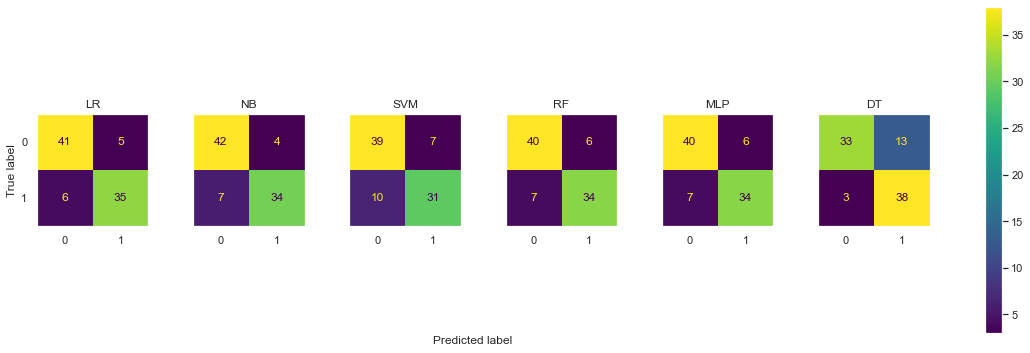

In [67]:
plot_cm2(models, X_train, X_test, y_train, y_test)

## Retirando Chol

<AxesSubplot:>

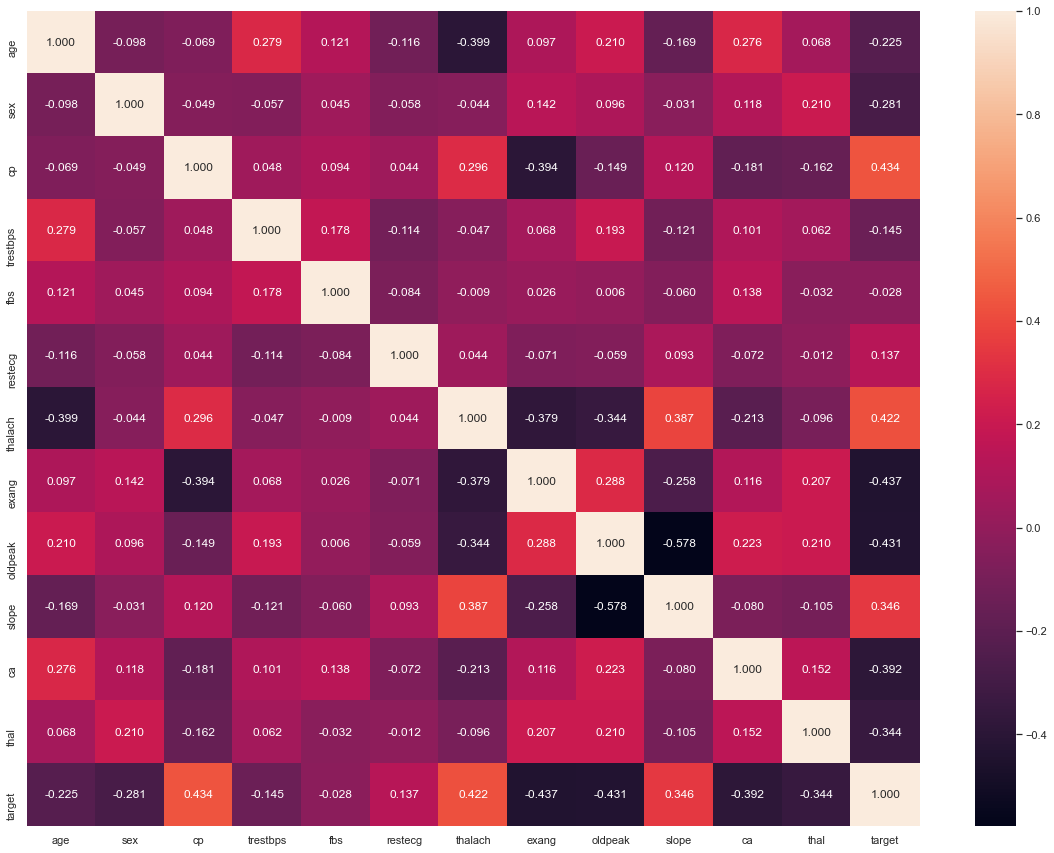

In [68]:
X = dados_v2.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, -1].values

matriz_correlacao = data.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12,13]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

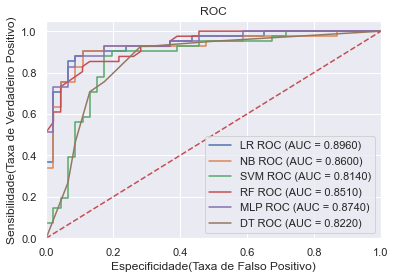

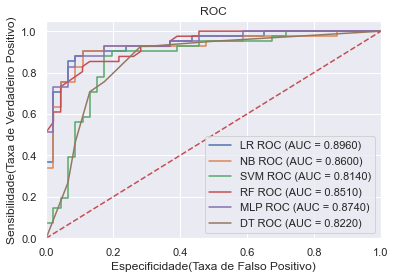

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True            chol      89.7  0.896057  0.895546   
1        NB        True            chol      86.2  0.861170  0.860286   
2       SVM        True            chol      81.6  0.814894  0.814157   
3        RF        True            chol      85.1  0.850258  0.850742   
4       MLP        True            chol      87.4  0.873295  0.873807   
5        DT        True            chol      81.6  0.815483  0.822110   

   Precisão    AUC  
0  0.896809  0.896  
1  0.862981  0.860  
2  0.816506  0.814  
3  0.850000  0.851  
4  0.873016  0.874  
5  0.830882  0.822

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, True, chol, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, chol, X_train, X_test, y_train, y_test, result)
df

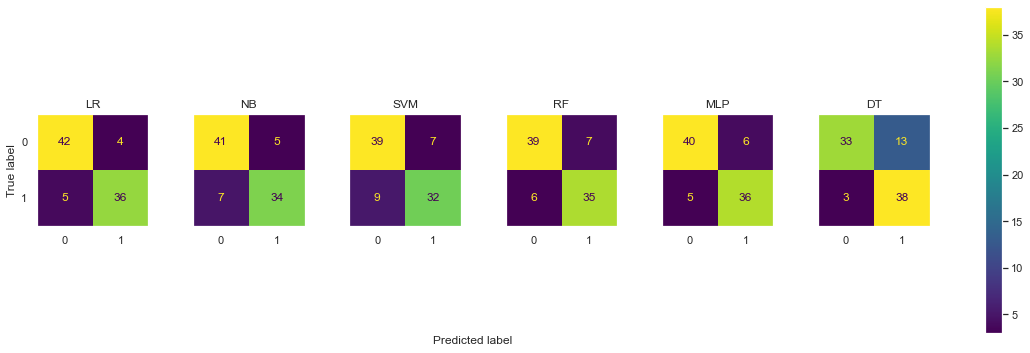

In [70]:
plot_cm2(models, X_train, X_test, y_train, y_test)

## Retirando fbs

<AxesSubplot:>

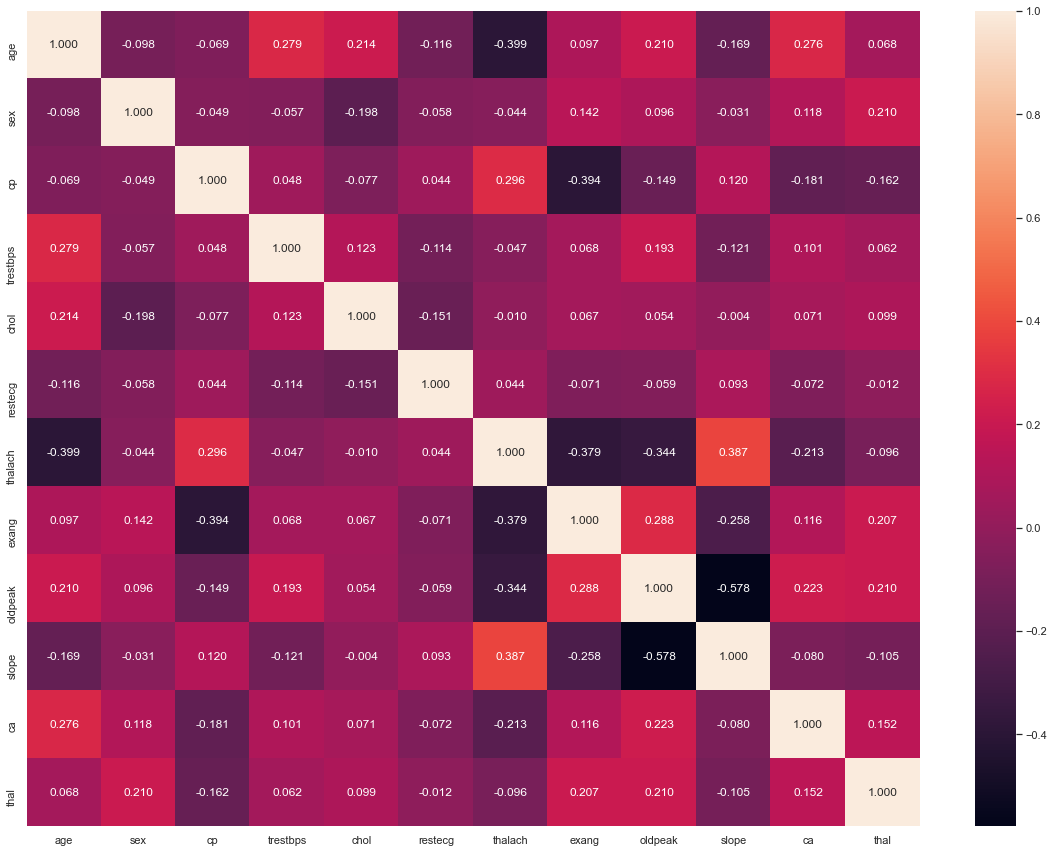

In [71]:
X = dados_v2.iloc[:, [0,1,2,3,4,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, -1].values

matriz_correlacao = data.iloc[:, [0,1,2,3,4,6,7,8,9,10,11,12]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

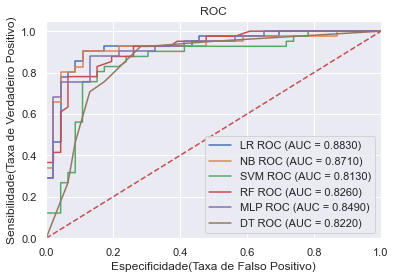

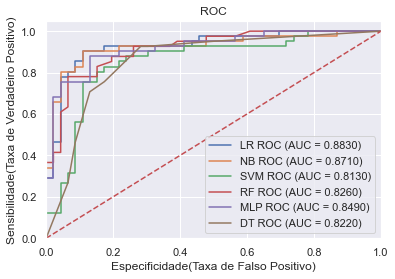

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True         thalach      88.5  0.884309  0.883351   
1        NB        True         thalach      87.4  0.872485  0.871156   
2       SVM        True         thalach      81.6  0.814103  0.812831   
3        RF        True         thalach      82.8  0.826762  0.826352   
4       MLP        True         thalach      85.1  0.849861  0.849417   
5        DT        True         thalach      81.6  0.815483  0.822110   

   Precisão    AUC  
0  0.886218  0.883  
1  0.875940  0.871  
2  0.818919  0.813  
3  0.827394  0.826  
4  0.850532  0.849  
5  0.830882  0.822

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, True, fbs, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, fbs, X_train, X_test, y_train, y_test, result)
df

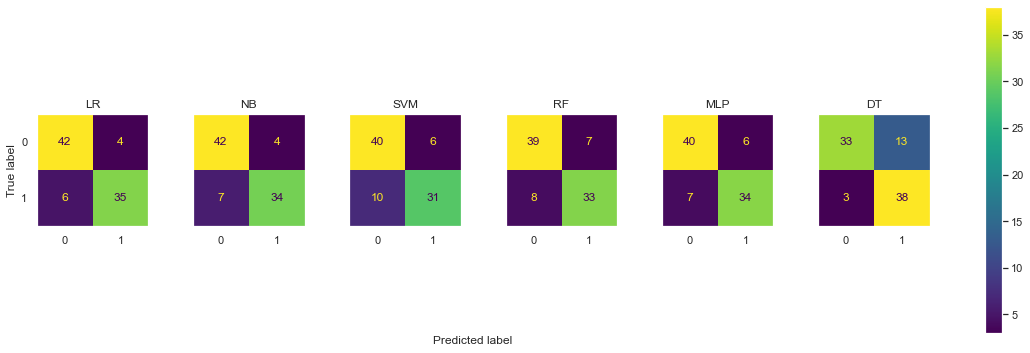

In [73]:
plot_cm2(models, X_train, X_test, y_train, y_test)

## Retirando rest

<AxesSubplot:>

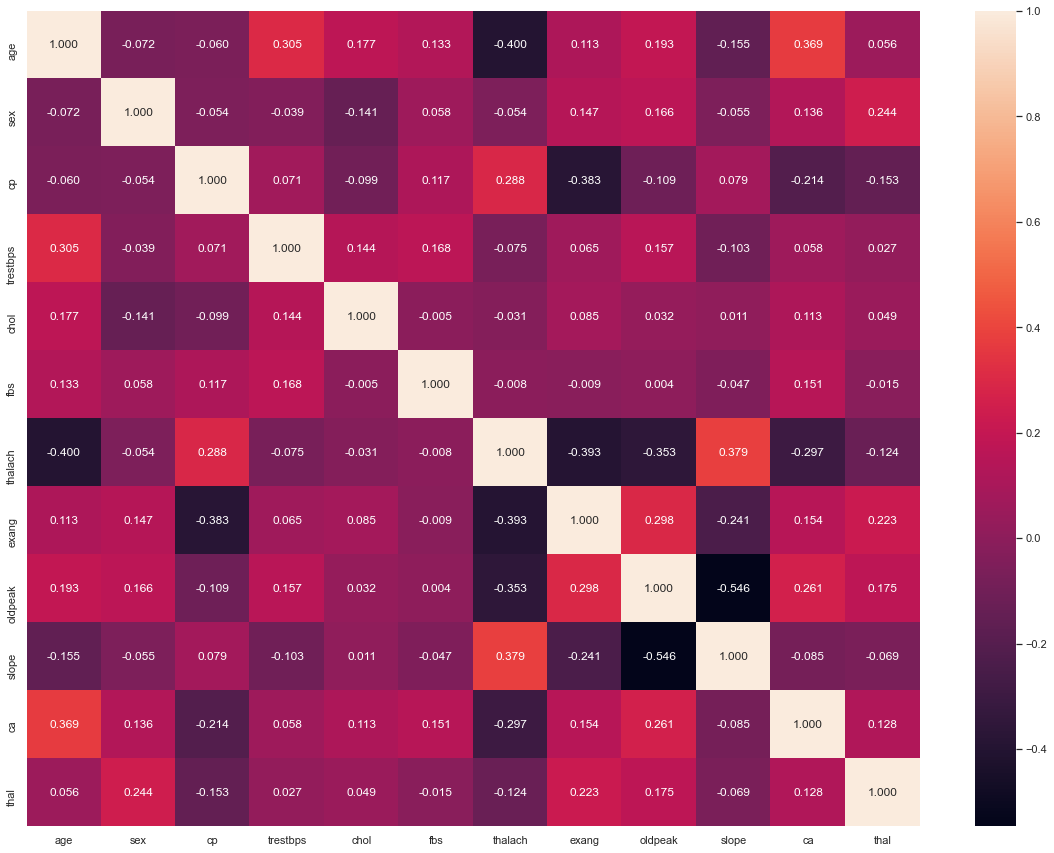

In [74]:
X = dados_v2.iloc[:, [0,1,2,3,4,5,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, -1].values

matriz_correlacao = dados_v2.iloc[:, [0,1,2,3,4,5,7,8,9,10,11,12]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

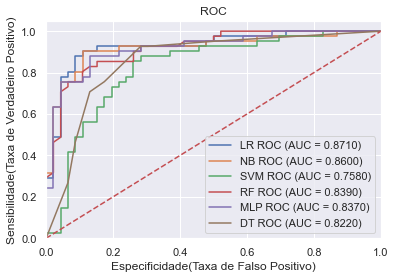

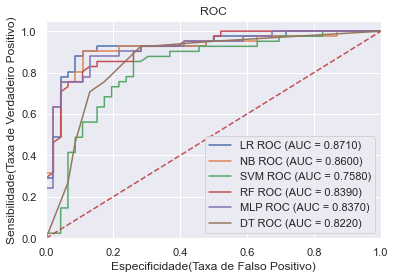

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True         restecg      87.4  0.872485  0.871156   
1        NB        True         restecg      86.2  0.861170  0.860286   
2       SVM        True         restecg      75.9  0.758109  0.758484   
3        RF        True         restecg      83.9  0.838547  0.838547   
4       MLP        True         restecg      83.9  0.838032  0.837222   
5        DT        True         restecg      81.6  0.815483  0.822110   

   Precisão    AUC  
0  0.875940  0.871  
1  0.862981  0.860  
2  0.757937  0.758  
3  0.838547  0.839  
4  0.839744  0.837  
5  0.830882  0.822

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, True, restecg, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, restecg, X_train, X_test, y_train, y_test, result)
df

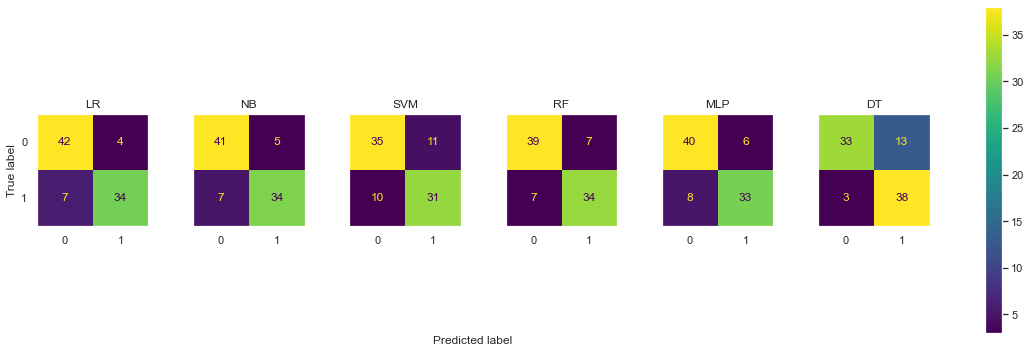

In [76]:
plot_cm2(models, X_train, X_test, y_train, y_test)

## Retirando todas 

<AxesSubplot:>

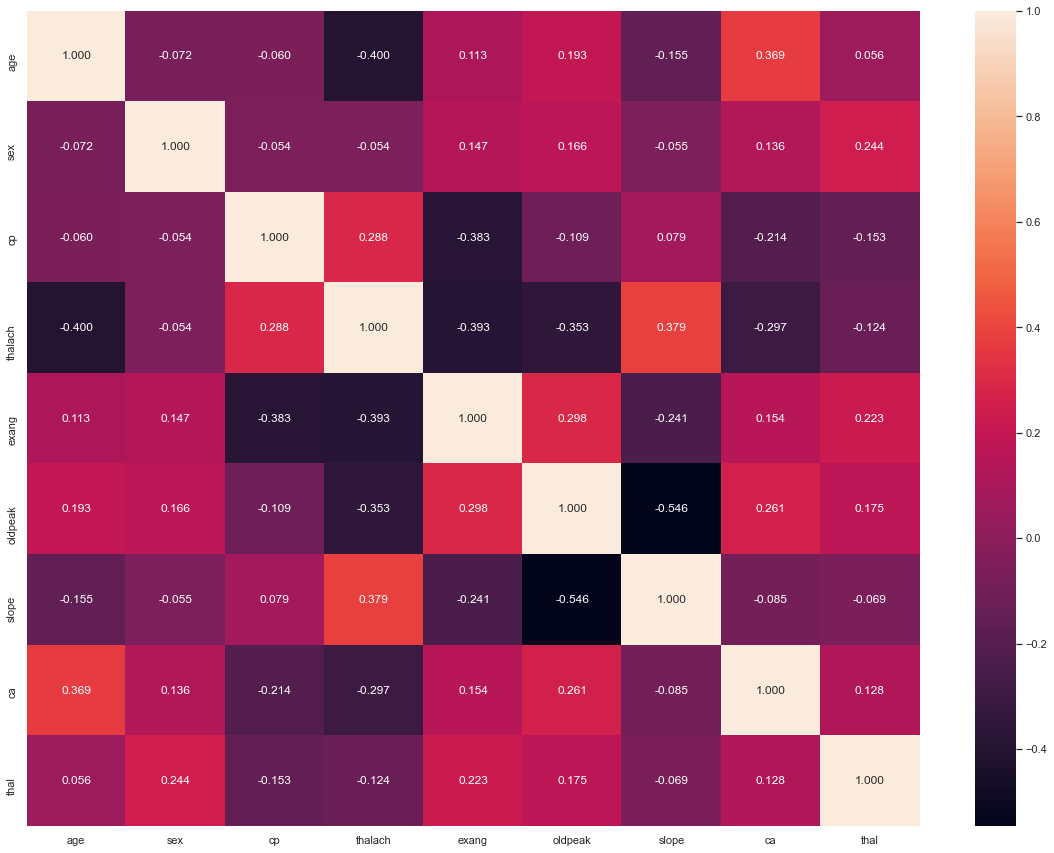

In [77]:
X = dados_v2.iloc[:, [0,1,2,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, -1].values

matriz_correlacao = dados_v2.iloc[:, [0,1,2,7,8,9,10,11,12]].corr()
plt.figure(figsize= (20, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = '.3f')

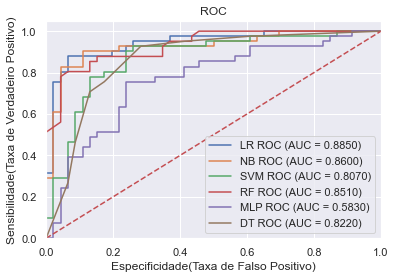

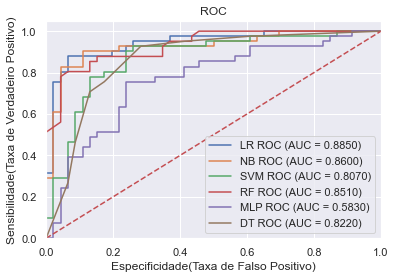

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0        LR        True           todas      88.5  0.884677  0.884677   
1        NB        True           todas      86.2  0.861170  0.860286   
2       SVM        True           todas      80.5  0.804598  0.807264   
3        RF        True           todas      85.1  0.850258  0.850742   
4       MLP        True           todas      56.3  0.516667  0.582980   
5        DT        True           todas      81.6  0.815483  0.822110   

   Precisão    AUC  
0  0.884677  0.885  
1  0.862981  0.860  
2  0.807264  0.807  
3  0.850000  0.851  
4  0.653131  0.583  
5  0.830882  0.822

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict()

df_results, _, _ = evaluate_model(models, True, all_classes, X_train, X_test, y_train, y_test, results)
df, acc,_ = evaluate_model(models, True, all_classes, X_train, X_test, y_train, y_test, result)
df

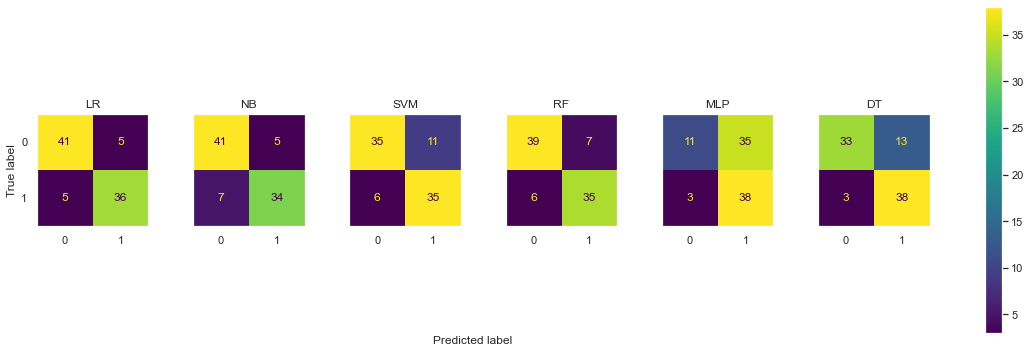

In [79]:
plot_cm2(models, X_train, X_test, y_train, y_test)

In [80]:
df_results

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0         LR        True        trestbps      87.4  0.872959  0.872481   
1         NB        True        trestbps      87.4  0.872485  0.871156   
2        SVM        True        trestbps      80.5  0.802931  0.801962   
3         RF        True        trestbps      85.1  0.849861  0.849417   
4        MLP        True        trestbps      85.1  0.849861  0.849417   
5         DT        True        trestbps      81.6  0.815483  0.822110   
6         LR        True            chol      89.7  0.896057  0.895546   
7         NB        True            chol      86.2  0.861170  0.860286   
8        SVM        True            chol      81.6  0.814894  0.814157   
9         RF        True            chol      85.1  0.850258  0.850742   
10       MLP        True            chol      87.4  0.873295  0.873807   
11        DT        True            chol      81.6  0.815483  0.822110   
12        LR        True         thalach      88.5  0.884309  0.883351   
13        NB        True         thalach      87.4  0.872485  0.871156   
14       SVM        True         thalach      81.6  0.814103  0.812831   
15        RF        True         thalach      82.8  0.826762  0.826352   
16       MLP        True         thalach      85.1  0.849861  0.849417   
17        DT        True         thalach      81.6  0.815483  0.822110   
18        LR        True         restecg      87.4  0.872485  0.871156   
19        NB        True         restecg      86.2  0.861170  0.860286   
20       SVM        True         restecg      75.9  0.758109  0.758484   
21        RF        True         restecg      83.9  0.838547  0.838547   
22       MLP        True         restecg      83.9  0.838032  0.837222   
23        DT        True         restecg      81.6  0.815483  0.822110   
24        LR        True           todas      88.5  0.884677  0.884677   
25        NB        True           todas      86.2  0.861170  0.860286   
26       SVM        True           todas      80.5  0.804598  0.807264   
27        RF        True           todas      85.1  0.850258  0.850742   
28       MLP        True           todas      56.3  0.516667  0.582980   
29        DT        True           todas      81.6  0.815483  0.822110   

    Precisão    AUC  
0   0.873670  0.872  
1   0.875940  0.871  
2   0.805854  0.802  
3   0.850532  0.849  
4   0.850532  0.849  
5   0.830882  0.822  
6   0.896809  0.896  
7   0.862981  0.860  
8   0.816506  0.814  
9   0.850000  0.851  
10  0.873016  0.874  
11  0.830882  0.822  
12  0.886218  0.883  
13  0.875940  0.871  
14  0.818919  0.813  
15  0.827394  0.826  
16  0.850532  0.849  
17  0.830882  0.822  
18  0.875940  0.871  
19  0.862981  0.860  
20  0.757937  0.758  
21  0.838547  0.839  
22  0.839744  0.837  
23  0.830882  0.822  
24  0.884677  0.885  
25  0.862981  0.860  
26  0.807264  0.807  
27  0.850000  0.851  
28  0.653131  0.583  
29  0.830882  0.822

In [81]:
df_sorted_com_all = df_results.sort_values(["Acurácia", "AUC"], ascending=False)

In [82]:
df_sorted_com_all

Algoritmo  Tratamento Classe_retirada  Acurácia  F1_score   Taxa_VP  \
6         LR        True            chol      89.7  0.896057  0.895546   
24        LR        True           todas      88.5  0.884677  0.884677   
12        LR        True         thalach      88.5  0.884309  0.883351   
10       MLP        True            chol      87.4  0.873295  0.873807   
0         LR        True        trestbps      87.4  0.872959  0.872481   
1         NB        True        trestbps      87.4  0.872485  0.871156   
13        NB        True         thalach      87.4  0.872485  0.871156   
18        LR        True         restecg      87.4  0.872485  0.871156   
7         NB        True            chol      86.2  0.861170  0.860286   
19        NB        True         restecg      86.2  0.861170  0.860286   
25        NB        True           todas      86.2  0.861170  0.860286   
9         RF        True            chol      85.1  0.850258  0.850742   
27        RF        True           todas      85.1  0.850258  0.850742   
3         RF        True        trestbps      85.1  0.849861  0.849417   
4        MLP        True        trestbps      85.1  0.849861  0.849417   
16       MLP        True         thalach      85.1  0.849861  0.849417   
21        RF        True         restecg      83.9  0.838547  0.838547   
22       MLP        True         restecg      83.9  0.838032  0.837222   
15        RF        True         thalach      82.8  0.826762  0.826352   
5         DT        True        trestbps      81.6  0.815483  0.822110   
11        DT        True            chol      81.6  0.815483  0.822110   
17        DT        True         thalach      81.6  0.815483  0.822110   
23        DT        True         restecg      81.6  0.815483  0.822110   
29        DT        True           todas      81.6  0.815483  0.822110   
8        SVM        True            chol      81.6  0.814894  0.814157   
14       SVM        True         thalach      81.6  0.814103  0.812831   
26       SVM        True           todas      80.5  0.804598  0.807264   
2        SVM        True        trestbps      80.5  0.802931  0.801962   
20       SVM        True         restecg      75.9  0.758109  0.758484   
28       MLP        True           todas      56.3  0.516667  0.582980   

    Precisão    AUC  
6   0.896809  0.896  
24  0.884677  0.885  
12  0.886218  0.883  
10  0.873016  0.874  
0   0.873670  0.872  
1   0.875940  0.871  
13  0.875940  0.871  
18  0.875940  0.871  
7   0.862981  0.860  
19  0.862981  0.860  
25  0.862981  0.860  
9   0.850000  0.851  
27  0.850000  0.851  
3   0.850532  0.849  
4   0.850532  0.849  
16  0.850532  0.849  
21  0.838547  0.839  
22  0.839744  0.837  
15  0.827394  0.826  
5   0.830882  0.822  
11  0.830882  0.822  
17  0.830882  0.822  
23  0.830882  0.822  
29  0.830882  0.822  
8   0.816506  0.814  
14  0.818919  0.813  
26  0.807264  0.807  
2   0.805854  0.802  
20  0.757937  0.758  
28  0.653131  0.583

In [83]:
df_sorted_com_all.drop(['Tratamento', 'F1_score', 'Taxa_VP', 'Precisão'], axis='columns', inplace=True)

<AxesSubplot:>

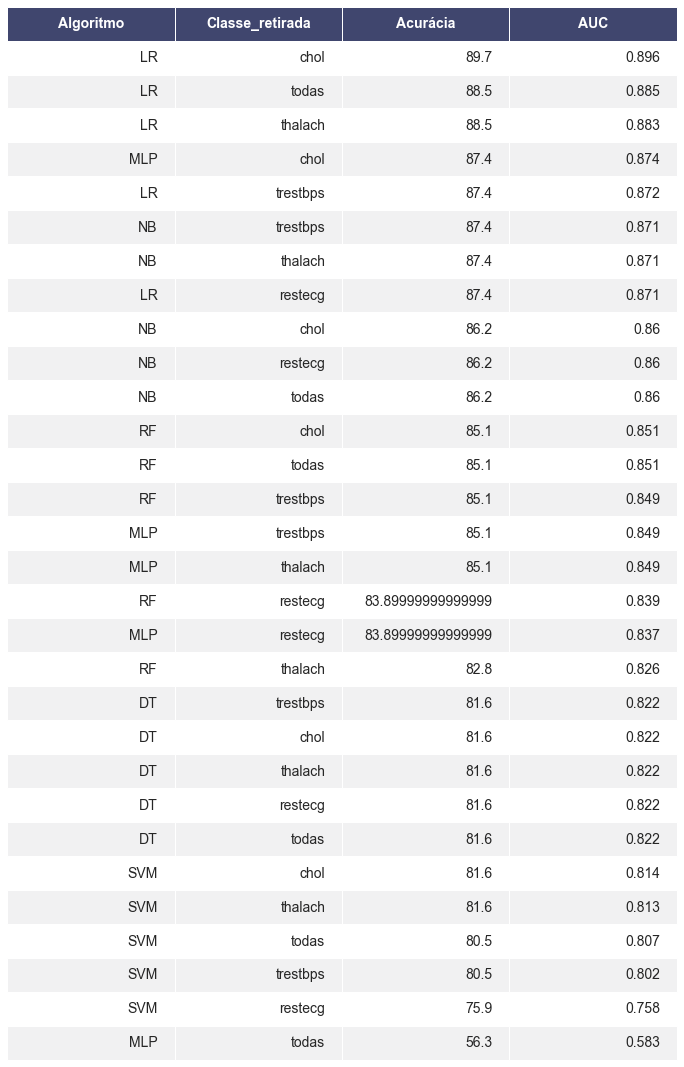

In [84]:
render_mpl_table(df_sorted_com_all)

In [85]:
df_com_without_duplicate = df_sorted_com_all.drop_duplicates(subset='Algoritmo', keep='first')
df_com_without_duplicate

Algoritmo Classe_retirada  Acurácia    AUC
6         LR            chol      89.7  0.896
10       MLP            chol      87.4  0.874
1         NB        trestbps      87.4  0.871
9         RF            chol      85.1  0.851
5         DT        trestbps      81.6  0.822
8        SVM            chol      81.6  0.814

<AxesSubplot:>

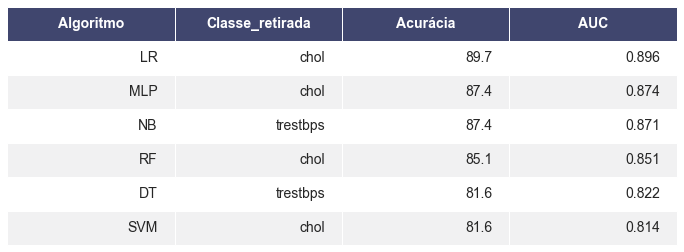

In [86]:
render_mpl_table(df_com_without_duplicate)

# Grid Search para os dois melhores algoritmos em acuracia retirando Chol.

In [166]:
X = dados_v2.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, -1].values

model = LogisticRegression()

solvers = ['lbfgs', 'liblinear']
penalty = ['l2', 'l1']
c_values = np.linspace(0, 20)
iters = [100, 200, 300, 400, 500, 1000]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=iters)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.854840 using {'C': 9.795918367346939, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.0, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.0, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.0, 'max_iter': 200, 'penalty': 'l1', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.0, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.0, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.0, 'max_iter': 300, 'penalty': 'l2', 'sol

C:\Users\wellk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
31800 fits failed out of a total of 120000.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\wellk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\wellk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1589, in fit
    fold_coefs_ = Parallel(
  File "C:\Users\wellk\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\wellk\anaconda3\l

In [88]:
X = dados_v2.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12]].values
y = dados_v2.iloc[:, 13].values

n_estimators = [50, 100, 200, 300, 400]
max_depth = [5,10,20,30,40,50]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
criterion = ['gini', 'entropy']

param_grid = {
    'criterion': criterion,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}


model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.852299 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
0.833662 (0.060102) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.839245 (0.068470) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.839327 (0.063912) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.840435 (0.065414) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
0.836987 (0.069222) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
0.839368 (0.062327) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.835837 (0.070138) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_lea

# Melhores Modelos encontrados

In [186]:
def models_dict_grid_todos():
    models = {
        'MLP': MLPClassifier(activation='relu', hidden_layer_sizes=(5,), 
                                 solver='lbfgs', random_state=0, max_iter=1000),
        'RF': RandomForestClassifier(random_state = 0, 
                                     criterion='entropy', 
                                     max_depth=5,
                                     min_samples_leaf=4,
                                     min_samples_split=10, 
                                     n_estimators = 100),
        'LR': LogisticRegression(max_iter=800, C=9.8, 
                                 penalty='l2', solver='lbfgs'),
    }

    return models

#  0.854840 using {'C': 9.795918367346939, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
# Best: 0.854138 using {'C': 1.9306977288832505, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
# Best: 0.853793 using {'C': 1.9306977288832505, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
# Best: 0.849836 using {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

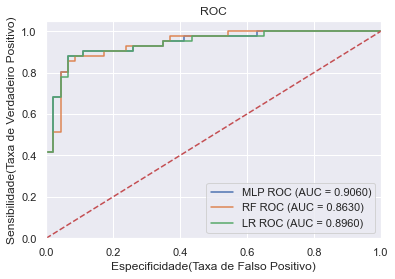

Algoritmo  Tratamento  Classe_retirada  Acurácia  F1_score   Taxa_VP  \
0       MLP        True            False      90.8  0.907447  0.906416   
1        RF        True            False      86.2  0.861905  0.862937   
2        LR        True            False      89.7  0.896057  0.895546   

   Precisão    AUC  
0  0.909455  0.906  
1  0.861786  0.863  
2  0.896809  0.896

In [187]:
X = dados_v2.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12]]
y = dados_v2.iloc[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

result = {
    "Algoritmo": [],
    "Tratamento": [],
    "Classe_retirada": [],
    "Acurácia": [],
    "F1_score": [],
    "Taxa_VP": [],
    "Precisão": [],
    "AUC": []
}

models = models_dict_grid_todos()

df,_,model =evaluate_model(models,True,False, X_train, X_test, y_train, y_test, result)
df

<AxesSubplot:>

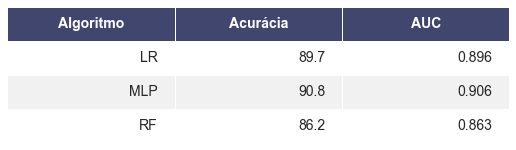

In [188]:
df = order_df_by_algortihm(df)
render_mpl_table(df)

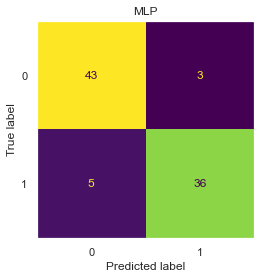

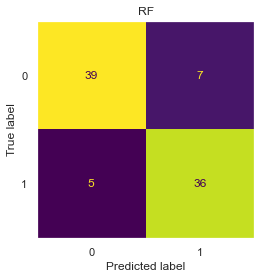

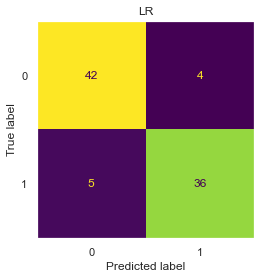

In [92]:
plot_cm3(models, X_train, X_test, y_train, y_test)

# Testes MLP

In [189]:
X = dados_v2.iloc[:, [0,1,2,3,5,6,7,8,9,10,11,12]]
y = dados_v2.iloc[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [198]:
def evaluate_mlp(X, y, units):
    scores = list()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    for unit in units:
        rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(unit,8),
                                 learning_rate='constant', solver='lbfgs', random_state=0, max_iter=1000)
        rn_heart_disease.fit(X_train, y_train)
        y_pred = rn_heart_disease.predict(X_test)
        scores.append(round(accuracy_score(y_test, y_pred)*100,2))
        print(round(accuracy_score(y_test, y_pred) *100,2))
    return scores

units = [5,10,15,20]
scores = evaluate_mlp(X, y, units)

C:\Users\wellk\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


90.8
78.16
83.91
80.46


In [197]:
def evaluate_mlp(X, y, units):
    scores = list()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    for unit in units:
        rn_heart_disease = MLPClassifier(activation='relu', hidden_layer_sizes=(unit),
                                 learning_rate='constant', solver='lbfgs', random_state=0, max_iter=1000)
        rn_heart_disease.fit(X_train, y_train)
        y_pred = rn_heart_disease.predict(X_test)
        scores.append(round(accuracy_score(y_test, y_pred)*100,2))
        print(round(accuracy_score(y_test, y_pred) *100,2))
    return scores

units = [5,10,15,20]
scores = evaluate_mlp(X, y, units)

90.8
88.51
78.16
83.91


C:\Users\wellk\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# VOTING 

In [119]:
def models_dict_grid_todos():
    models = {
        'MLP': MLPClassifier(activation='relu', hidden_layer_sizes=(5), 
                                 solver='lbfgs', random_state=0, max_iter=500),
        'RF': RandomForestClassifier(random_state = 0, 
                                     criterion='entropy', 
                                     max_depth=30,
                                     min_samples_leaf=4,
                                     min_samples_split=10, 
                                     n_estimators = 200),
        'LR': LogisticRegression(max_iter=100, C=1.93, 
                                 penalty='l1', solver='liblinear', tol=0.0001),
    }

    return models

# Best: 0.855554 using {'C': 1.9306977288832505, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
# Best: 0.855583 using {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from mlxtend.classifier import EnsembleVoteClassifier

In [121]:
result = {
    "Modelo": [],
    "Acurácia": [],
}

X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
y = dados_v2.iloc[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [122]:
model_lrc = LogisticRegression(max_iter=100, C=1.93, 
                                 penalty='l1', solver='liblinear', tol=0.0001)

lr_model = model_lrc.fit(X_train, y_train)
pred_lr = lr_model.predict(X_test)

acc = round(accuracy_score(y_test, pred_lr),3) * 100
result['Modelo'].append('LR')
result['Acurácia'].append(acc)

result

{'Modelo': ['LR'], 'Acurácia': [88.5]}

In [123]:
mlp_model = MLPClassifier(activation='relu', hidden_layer_sizes=(10,8), 
                                 solver='lbfgs', random_state=0, max_iter=500)

model_mlp = mlp_model.fit(X_train, y_train)
pred_mlp = model_mlp.predict(X_test)

acc = round(accuracy_score(y_test, pred_mlp),3) * 100
result['Modelo'].append('MLP')
result['Acurácia'].append(acc)

result

{'Modelo': ['LR', 'MLP'], 'Acurácia': [88.5, 90.8]}

In [124]:
rf_model = RandomForestClassifier(random_state = 0, 
                                     criterion='entropy', 
                                     max_depth=30,
                                     min_samples_leaf=4,
                                     min_samples_split=10, 
                                     n_estimators = 200)

model_rf = rf_model.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)

acc = round(accuracy_score(y_test, pred_rf),3) * 100
result['Modelo'].append('RF')
result['Acurácia'].append(acc)

result

{'Modelo': ['LR', 'MLP', 'RF'], 'Acurácia': [88.5, 90.8, 87.4]}

In [125]:


clfs = [lr_model, model_mlp, rf_model]

model_clfs = EnsembleVoteClassifier(
    clfs = clfs,
    voting = "soft",
    weights = [1,1,1]
)

clfs_model = model_clfs.fit(X_train, y_train)
pred_clfs = clfs_model.predict(X_test)

acc = round(accuracy_score(y_test, pred_clfs),3) * 100
result['Modelo'].append('VS')
result['Acurácia'].append(acc)

result

{'Modelo': ['LR', 'MLP', 'RF', 'VS'], 'Acurácia': [88.5, 90.8, 87.4, 89.7]}

In [126]:
clfs = [lr_model, model_mlp, rf_model]

model_clfs = EnsembleVoteClassifier(
    clfs = clfs,
    voting = "hard"
)

clfs_model = model_clfs.fit(X_train, y_train)
pred_clfs = clfs_model.predict(X_test)

acc = round(accuracy_score(y_test, pred_clfs),3) * 100
result['Modelo'].append('VH')
result['Acurácia'].append(acc)

result

{'Modelo': ['LR', 'MLP', 'RF', 'VS', 'VH'],
 'Acurácia': [88.5, 90.8, 87.4, 89.7, 89.7]}

In [127]:
df = pd.DataFrame(result)

<AxesSubplot:>

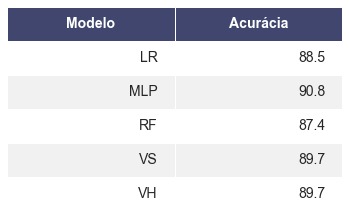

In [128]:
render_mpl_table(df)

# Empilhamento Stacked

>LR 85.46 (0.07)
>MLP 85.23 (0.06)
>RF 84.98 (0.06)
>STACKING 85.92 (0.07)


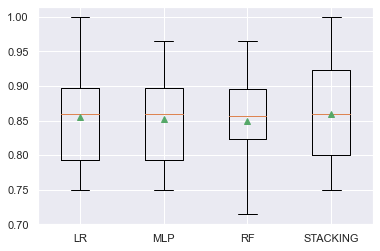

In [129]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot


def get_dataset():
    X = dados_v2.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12]]
    y = dados_v2.iloc[:, 13]
    return X, y


def get_stacking():
    level0 = list()
    level0.append(('LR', LogisticRegression(max_iter=100, C=1.93, 
                                 penalty='l1', solver='liblinear', tol=0.0001)))
    level0.append(('MLP', MLPClassifier(activation='relu', hidden_layer_sizes=(10,8), 
                                 solver='lbfgs', random_state=0, max_iter=500)))
    level0.append(('RF', RandomForestClassifier(random_state = 0, 
                                     criterion='entropy', 
                                     max_depth=30,
                                     min_samples_leaf=4,
                                     min_samples_split=10, 
                                     n_estimators = 200)))
    level1 = LogisticRegression()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

def get_models():
    models = dict()
    models['LR'] = LogisticRegression(max_iter=100, C=1.93, 
                                 penalty='l1', solver='liblinear', tol=0.0001)
    models['MLP'] = MLPClassifier(activation='relu', hidden_layer_sizes=(10,8), 
                                 solver='lbfgs', random_state=0, max_iter=500)
    models['RF'] = RandomForestClassifier(random_state = 0, 
                                     criterion='entropy', 
                                     max_depth=30,
                                     min_samples_leaf=4,
                                     min_samples_split=10, 
                                     n_estimators = 200)
    models['STACKING'] = get_stacking()
    return models

def evaluate_model_stacking_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

X, y = get_dataset()
models = get_models()
results, names, acc = list(), list(), list()
for name, model in models.items():
    scores = evaluate_model_stacking_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.2f (%.2f)' % (name, mean(scores) * 100, std(scores)))
    acc.append(round(mean(scores) * 100,2))
pyplot.boxplot(results, labels=names, showmeans=True)

pyplot.show()

<AxesSubplot:>

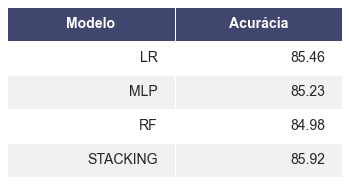

In [130]:
results = {
    "Modelo": names,
    "Acurácia": acc
}

df = pd.DataFrame(results)
render_mpl_table(df)

# Hibrido